# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [x] [Exploring the data](#explore)
- [x] [Which training sample is best?](#sample)
- [x] [Which image representation is best?](#repr)
- [X] [Which network architecture works best?](#arch)
- [x] [Which channel configuration is best?](#channel)
- [x] [Which categorisation is best?](#cat)
- [x] [Does escapes help cosmic classifier?](#cosmic)
- [x] [Does primary count help beam classifier?](#beam)
- [x] [Does lepton energy and vertex position help neutrino energy estimation?](#energy_multi)
- [X] [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [ ] [Model calibration sensitivity: time](#calib_time)
- [ ] [Model calibration sensitivity: charge random](#calib_charge_rand)
- [ ] [Model calibration sensitivity: charge shift](#calib_charge_shift)
- [ ] [Model calibration sensitivity: noise](#calib_noise)
- [x] [Clustering: cosmic classification](#cosmic_cluster)
- [x] [Clustering: beam classification](#beam_cluster)
- [x] [Explanation: cosmic/beam/energy](#explain)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/analysis/config.yaml"
save_path = "./data/output/"
nuel_map_file = "/unix/chips/jtingey/prod/nuel_all_numuflux/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/prod/numu_all_numuflux/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/prod/cosmics/map/chips_1200/selected_000_sim_map.root"
old_nuel_file = "./data/input/old_reco/old_reco_el.root"
old_numu_file = "./data/input/old_reco/old_reco_mu.root"
vac_osc_file_zero_f = "./data/input/oscillations/vac_osc_cp_zero.root"
vac_osc_file_plus_f = "./data/input/oscillations/vac_osc_cp_plushalfpi.root"
vac_osc_file_minus_f = "./data/input/oscillations/vac_osc_cp_minushalfpi.root"
matter_osc_file_zero_f = "./data/input/oscillations/matter_osc_cp_zero.root"
matter_osc_file_plus_f = "./data/input/oscillations/matter_osc_cp_plushalfpi.root"
matter_osc_file_minus_f = "./data/input/oscillations/matter_osc_cp_minushalfpi.root"
total_flux_events = 1822592
total_uniform_events = 3086208
total_cosmic_events = 1327744

In [2]:
# Standard inports
import os
import logging
import importlib
import copy
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')
#if tf.config.list_physical_devices('GPU'):
#    try:  # Currently, memory growth needs to be the same across GPUs
#        for gpu in gpus:
#            tf.config.experimental.set_memory_growth(gpu, True)
#    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
#        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}

style = hep.style.ROOT
del style['xaxis.labellocation']
del style['yaxis.labellocation']
plt.style.use([style, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
s_both_ev, s_both_out = chipsnet.utils.evaluate(config, "sample_both_cosmic")
s_flux_ev, s_flux_out = chipsnet.utils.evaluate(config, "sample_flux_cosmic")
s_uniform_ev, s_uniform_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux_cosmic")


************************ Evaluating sample_both_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (384899,0.00871), (0,0.00000), (259648,4.66284)
Cuts:    (281796,0.95429), (274862,0.92423), (123442,0.71910), (53411,0.20571)
took 362.40 seconds

************************ Evaluating sample_flux_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (198914,0.01686), (0,0.00000), (353008,3.42966)
Cuts:    (165397,0.94681), (157159,0.91504), (35579,0.66250), (72590,0.20563)
took 146.45 seconds

************************ Evaluating sample_uniform_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (286487,0.01170), (0,0.00000), (352903,3.43068)
Cuts:    (191131,0.96049), (182383,0.93058), (133632,0.73773), (72557,0.20560)
took 163.44 seconds

************************ Evaluating flux_cosmic ************************
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,4.75840)
Cuts:    (396410,0.96036), (227860,0.

In [8]:
# Get oscillation arrays...
vac_osc_file_zero = uproot.open(vac_osc_file_zero_f)
vac_osc_file_plus = uproot.open(vac_osc_file_plus_f)
vac_osc_file_minus = uproot.open(vac_osc_file_minus_f)
matter_osc_file_zero = uproot.open(matter_osc_file_zero_f)
matter_osc_file_plus = uproot.open(matter_osc_file_plus_f)
matter_osc_file_minus = uproot.open(matter_osc_file_minus_f)

vac_numu_prop_zero = vac_osc_file_zero["hist_mumu"].values[113]
vac_nuel_prop_zero = vac_osc_file_zero["hist_mue"].values[113]
vac_numu_prop_plus = vac_osc_file_plus["hist_mumu"].values[113]
vac_nuel_prop_plus = vac_osc_file_plus["hist_mue"].values[113]
vac_numu_prop_minus = vac_osc_file_minus["hist_mumu"].values[113]
vac_nuel_prop_minus = vac_osc_file_minus["hist_mue"].values[113]

matter_numu_prop_zero = matter_osc_file_zero["hist_mumu"].values
matter_nuel_prop_zero = matter_osc_file_zero["hist_mue"].values
matter_numu_prop_plus = matter_osc_file_plus["hist_mumu"].values
matter_nuel_prop_plus = matter_osc_file_plus["hist_mue"].values
matter_numu_prop_minus = matter_osc_file_minus["hist_mumu"].values
matter_nuel_prop_minus = matter_osc_file_minus["hist_mue"].values

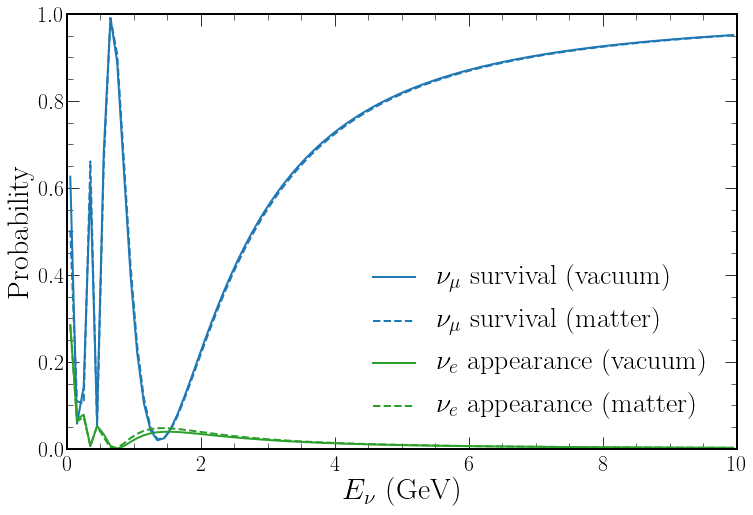

In [9]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.plot(energies, vac_numu_prop_zero, color="tab:blue", linewidth=2)
axs.plot(energies, vac_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_numu_prop_zero, color="tab:blue", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2, linestyle="dashed")
axs.set_ylim(0, 1)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Probability", fontsize=30)
vac_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$\nu_{\mu}$ survival (vacuum)")
vac_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\nu_{e}$ appearance (vacuum)")
matter_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="dashed", label=r"$\nu_{\mu}$ survival (matter)")
matter_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\nu_{e}$ appearance (matter)")
axs.legend(handles=[vac_numu, matter_numu, vac_nuel, matter_nuel], loc="lower right", fontsize=28)
chipsnet.plotting.save(save_path + "explore_osc_vac_vs_matter_probs")

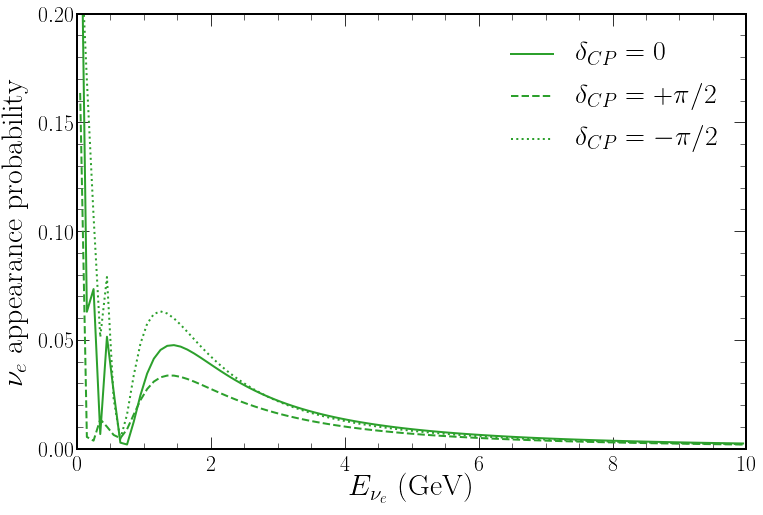

In [11]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
plt.setp(axs, yticks=[0, 0.05, 0.1, 0.15, 0.2])
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_nuel_prop_plus, color="tab:green", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_minus, color="tab:green", linewidth=2, linestyle="dotted")
axs.set_ylim(0, 0.2)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"$\nu_{e}$ appearance probability", fontsize=30)
zero_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\delta_{CP}=0$")
plus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\delta_{CP}=+\pi/2$")
minus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dotted", label=r"$\delta_{CP}=-\pi/2$")
axs.legend(handles=[zero_cp, plus_cp, minus_cp], loc="upper right", fontsize=28)
chipsnet.plotting.save(save_path + "explore_osc_cp_probs")

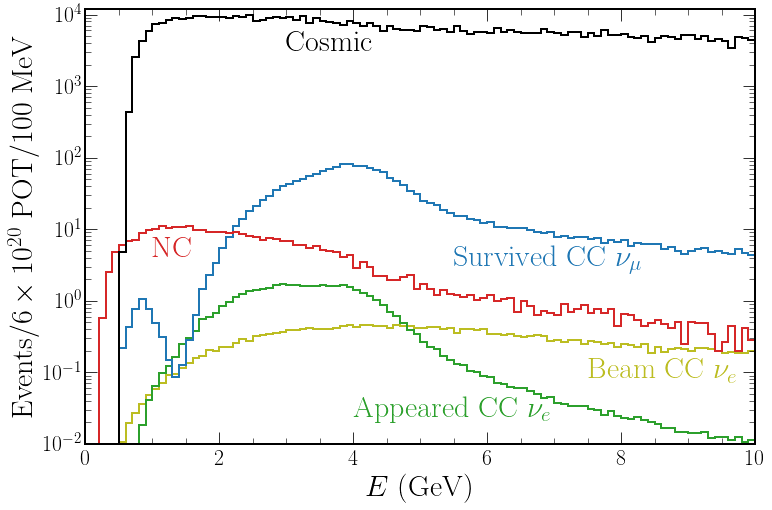

In [18]:
nuel_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 0) & 
    (flux_ev["t_sample_type"] == 0)
]
osc_nuel_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 0) & 
    (flux_ev["t_sample_type"] == 1)
]
numu_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 1) & 
    (flux_ev["t_sample_type"] == 0)
]
nc_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 2) & 
    (flux_ev["t_sample_type"] == 0)
]
cosmic_ev = flux_ev[flux_ev["t_comb_cat"] == 3]

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
axs.hist(nuel_ev["t_nu_energy"]/1000, weights=nuel_ev["w"], range=(0, 10), bins=100, color='tab:olive', histtype='step', linewidth=2)
axs.hist(osc_nuel_ev["t_nu_energy"]/1000, weights=osc_nuel_ev["w"], range=(0, 10), bins=100, color='tab:green', histtype='step', linewidth=2)
axs.hist(numu_ev["t_nu_energy"]/1000, weights=numu_ev["w"], range=(0, 10), bins=100, color='tab:blue', histtype='step', linewidth=2)
axs.hist(nc_ev["t_had_energy"]/1000, weights=nc_ev["w"], range=(0, 10), bins=100, color='tab:red', histtype='step', linewidth=2)
axs.hist(cosmic_ev["t_nu_energy"]/1000, weights=cosmic_ev["w"], range=(0, 10), bins=100, color='black', histtype='step', linewidth=2)
axs.text(5.5, 2.7, r"Survived CC $\nu_{\mu}$", color='tab:blue', fontsize=30)
axs.text(4, 0.02, r"Appeared CC $\nu_{e}$", color='tab:green', fontsize=30)
axs.text(7.5, 0.07, r"Beam CC $\nu_{e}$", color='tab:olive', fontsize=30)
axs.text(1, 4, r"NC", color='tab:red', fontsize=30)
axs.text(3, 3000, r"Cosmic", color='black', fontsize=30)
axs.set_yscale('log')
axs.set_xlabel(r"$E$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/100 MeV", fontsize=30)
axs.set_ylim(10e-3, 12e3)

chipsnet.plotting.save(save_path + "explore_osc_fluxes")

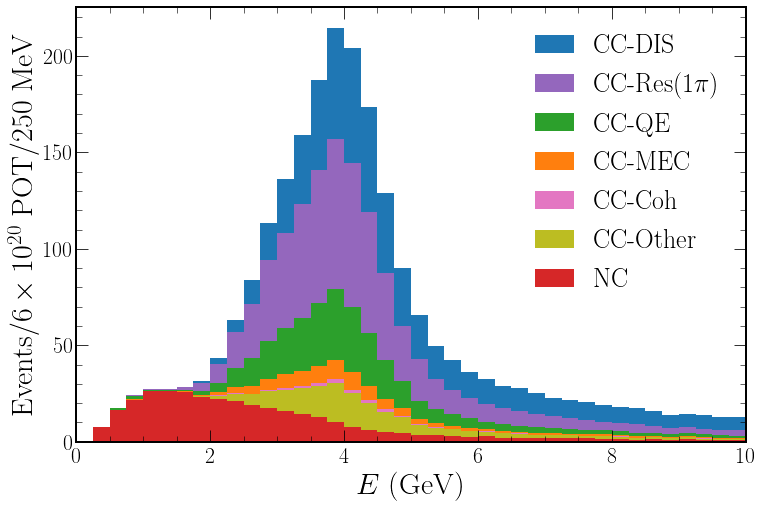

In [61]:
e_range=(0, 10)
e_bins=40
bin_range=(e_range[1]-e_range[0])/e_bins

qel_ev = flux_ev[flux_ev["t_cc_cat"] == 0].reset_index(drop=True)
res_ev = flux_ev[flux_ev["t_cc_cat"] == 1].reset_index(drop=True)
dis_ev = flux_ev[flux_ev["t_cc_cat"] == 2].reset_index(drop=True)
coh_ev = flux_ev[flux_ev["t_cc_cat"] == 3].reset_index(drop=True)
mec_ev = flux_ev[flux_ev["t_cc_cat"] == 4].reset_index(drop=True)
other_ev = flux_ev[flux_ev["t_cc_cat"] == 5].reset_index(drop=True)
nc_ev = nc_ev.reset_index(drop=True)

qel_h, qel_err, c, e = chipsnet.utils.extended_hist(qel_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=qel_ev["w"])
res_h, res_err, c, e = chipsnet.utils.extended_hist(res_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=res_ev["w"])
dis_h, dis_err, c, e = chipsnet.utils.extended_hist(dis_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=dis_ev["w"])
coh_h, coh_err, c, e = chipsnet.utils.extended_hist(coh_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=coh_ev["w"])
mec_h, mec_err, c, e = chipsnet.utils.extended_hist(mec_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=mec_ev["w"])
other_h, other_err, c, e = chipsnet.utils.extended_hist(other_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=other_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["t_had_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = qel_err + res_err + dis_err + coh_err + mec_err + other_err + nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)

axs.bar(bins, nc_h, bin_range, color="tab:red")
axs.bar(bins, other_h, bin_range, color="tab:olive", bottom=nc_h)
axs.bar(bins, coh_h, bin_range, color="tab:pink", bottom=nc_h+other_h)
axs.bar(bins, mec_h, bin_range, color="tab:orange", bottom=nc_h+other_h+coh_h)
axs.bar(bins, qel_h, bin_range, color="tab:green", bottom=nc_h+other_h+coh_h+mec_h)
axs.bar(bins, res_h, bin_range, color="tab:purple", bottom=nc_h+other_h+coh_h+mec_h+qel_h)
axs.bar(bins, dis_h, bin_range, color="tab:blue", bottom=nc_h+other_h+coh_h+mec_h+qel_h+res_h)

dis = Patch(facecolor="tab:blue", label=r"CC-DIS")
res = Patch(facecolor="tab:purple", label=r"CC-Res($1\pi$)")
qel = Patch(facecolor="tab:green", label=r"CC-QE")
mec = Patch(facecolor="tab:orange", label=r"CC-MEC")
coh = Patch(facecolor="tab:pink", label=r"CC-Coh")
other = Patch(facecolor="tab:olive", label=r"CC-Other")
nc = Patch(facecolor="tab:red", label=r"NC")
axs.legend(handles=[dis, res, qel, mec, coh, other, nc], loc="upper right", fontsize=26)
axs.set_xlabel(r"$E$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/250 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "explore_stacked_int_types")

In [64]:
def plot_training_sample(events, total_num, save_name, cosmic=True):
    data = [
        len(events[events["t_all_cat"] == i])
        for i in range(len(chipsnet.data.MAP_ALL_CAT["labels"]))
    ]
    scale = total_num/sum(data)
    data = [x * scale for x in data]
    labels = chipsnet.data.MAP_ALL_CAT["labels"]

    if cosmic is False:
        data = data[:-1]
        labels = labels[:-1]
        
    data = np.asarray(data)
    print("Total training events = {}".format(data.sum()))
    
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
    barlist = axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black', linewidth=2)
    if cosmic is True:
        barlist[16].set_color("tab:red")
        barlist[16].set_edgecolor("black")
        barlist[16].set_linewidth(2)
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=24, rotation="vertical")
    axs.set_ylabel("Number of training events", fontsize=30)
    axs.set_yscale('log')
    axs.set_ylim(10e2, 2e6)
    if cosmic is False:
        axs.set_ylim(10e2, 5e5)
    chipsnet.plotting.save(save_name)

In [65]:
data = [
    len(s_flux_ev[s_flux_ev["t_all_cat"] == i])
    for i in range(len(chipsnet.data.MAP_ALL_CAT["labels"]))
]
print(sum(data))

753152


Total training events = 3150336.0


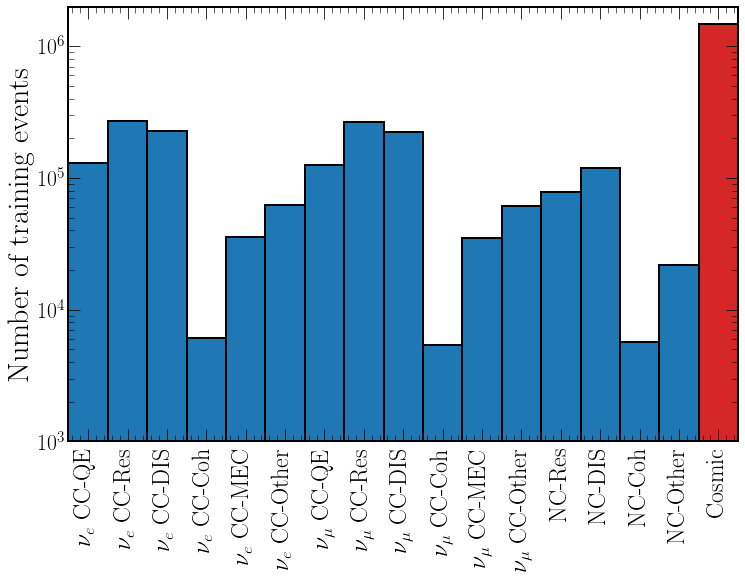

In [66]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events), save_path + "explore_cosmic_training_sample", cosmic=True)

Total training events = 1673749.8518014955


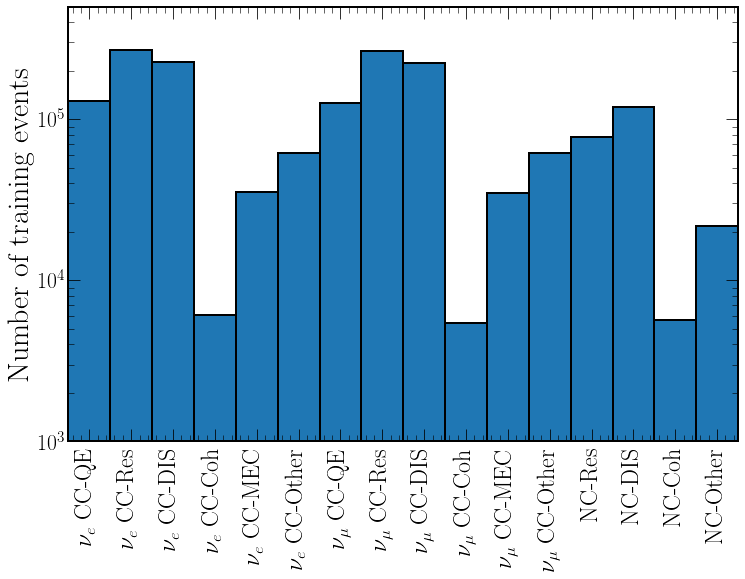

In [67]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events), save_path + "explore_beam_training_sample", cosmic=False)

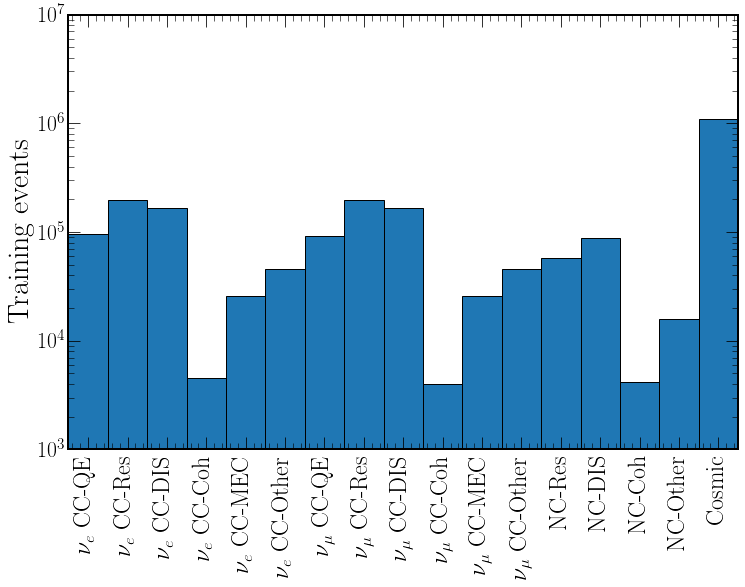

In [13]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_ALL_CAT, save_path)

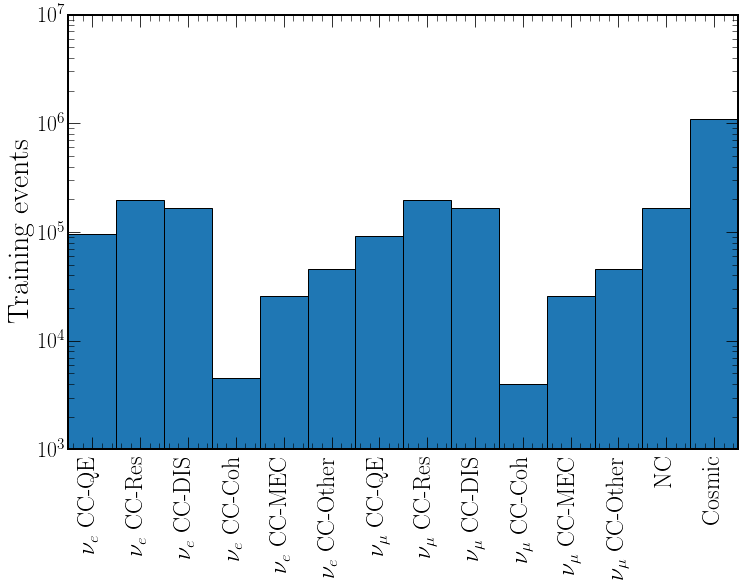

In [14]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_NC_COMB_CAT, save_path)

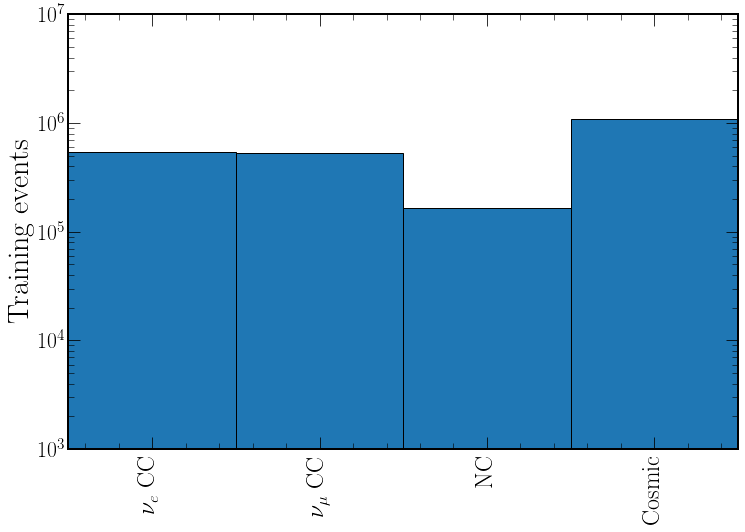

In [15]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

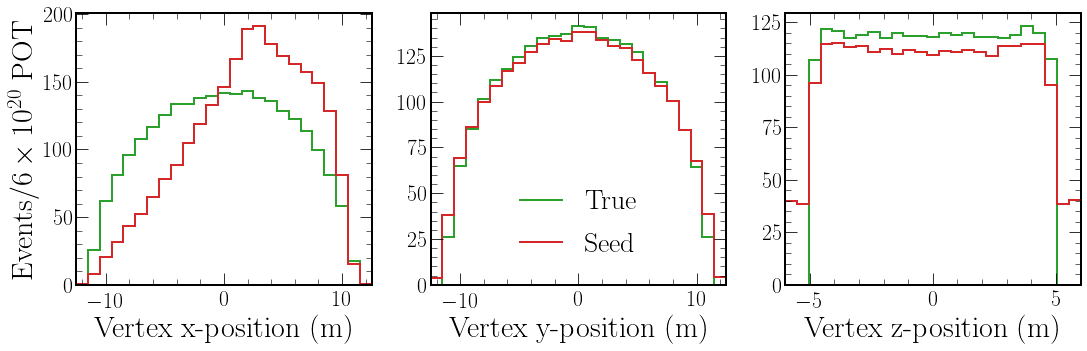

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100, 
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].set_xlabel('Vertex x-position (m)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"True")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Seed")
axs[1].legend(handles=[single, multi], loc="lower center", fontsize=28)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100,
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].set_xlabel('Vertex y-position (m)', fontsize=30)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100,
            range=(-6, 6), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100, 
            range=(-6, 6), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].set_xlabel('Vertex z-position (m)', fontsize=30)
chipsnet.plotting.save(save_path + "explore_vtx_positions")

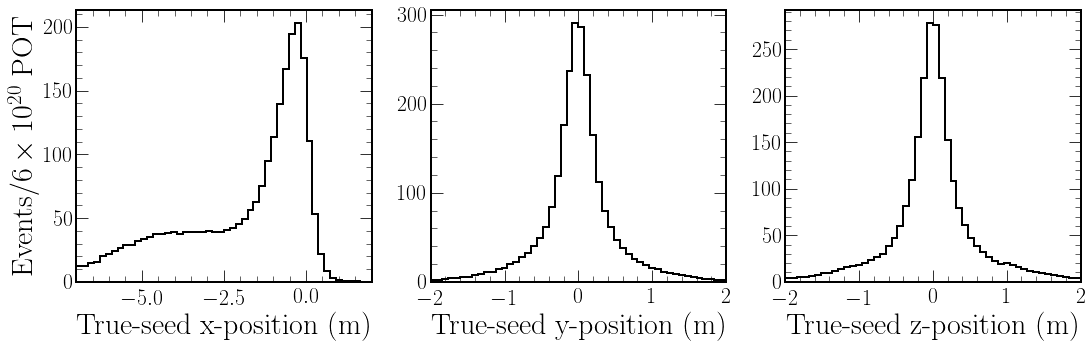

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-7, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[0].set_xlabel('True-seed x-position (m)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[1].set_xlabel('True-seed y-position (m)', fontsize=30)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100), 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[2].set_xlabel('True-seed z-position (m)', fontsize=30)
chipsnet.plotting.save(save_path + "explore_true_reco_vtx")

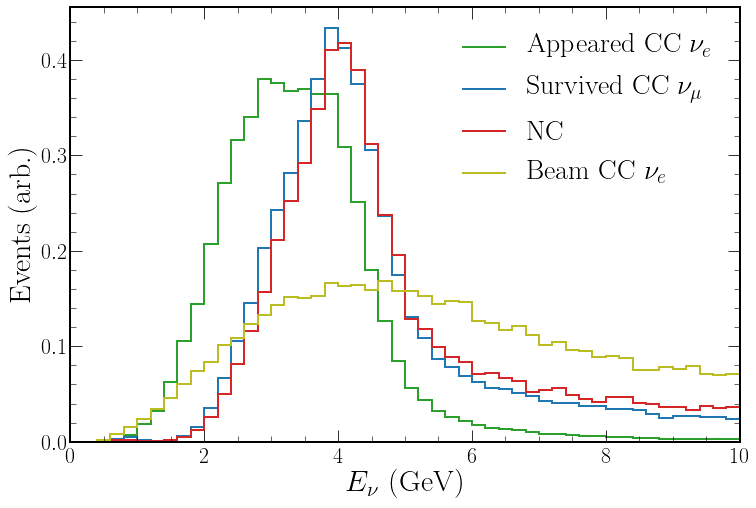

In [18]:
osc_nuel = matplotlib.lines.Line2D([], [], c='tab:green', linewidth=2)
numu = matplotlib.lines.Line2D([], [], c='tab:blue', linewidth=2)
nc = matplotlib.lines.Line2D([], [], c='tab:red', linewidth=2)
nuel = matplotlib.lines.Line2D([], [], c='tab:olive', linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["w"],
         range=(0, 10), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=50, color='tab:blue', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["w"],
         range=(0, 10), bins=50, color='tab:olive', histtype='step', density=True, linewidth=2)
axs.legend(loc="upper right", handles=[osc_nuel, numu, nc, nuel], fontsize=28, labels=[r"Appeared CC $\nu_{e}$", r"Survived CC $\nu_{\mu}$", r"NC", r"Beam CC $\nu_{e}$"])
axs.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=30)
axs.set_ylabel('Events (arb.)', fontsize=30)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
chipsnet.plotting.save(save_path + "explore_nu_energies")

In [6]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": [], "t_nu_energy": [], "t_lep_energy":[], "t_p_pdgs": [], "t_p_energies": [], "t_escapes": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4769380479133997


3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


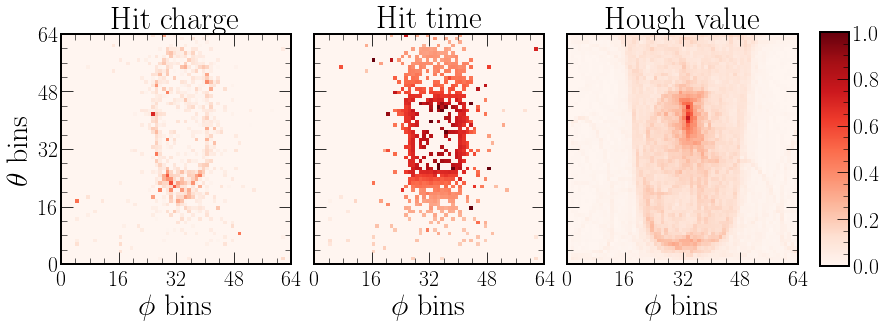

In [25]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_nuel_ccres_event")

91
3520.17
1862.55
[2212   13 2112  211  211   22 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2022.37  1862.55  1038.34   226.973  223.71     6.32  -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


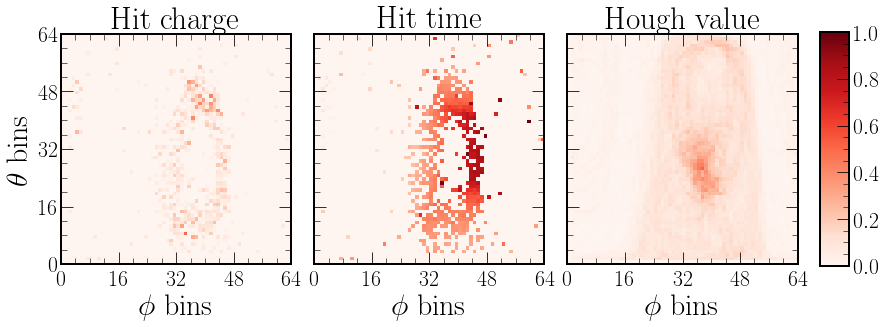

In [26]:
event_num = 2014
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_numu_ccdis_event")

100
2928.5
2928.5
[  13 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2928.5 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.
 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999. ]
0


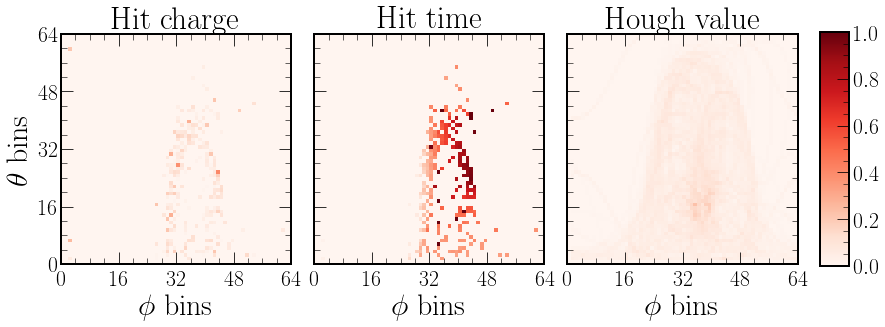

In [27]:
event_num = 4006
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_cosmic_event")

92
9301.59
-1.0
[  12 2212  211 2212 2212 2112 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[4731.25  2635.15  2511.54  1046.97   998.676  993.868 -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
-1


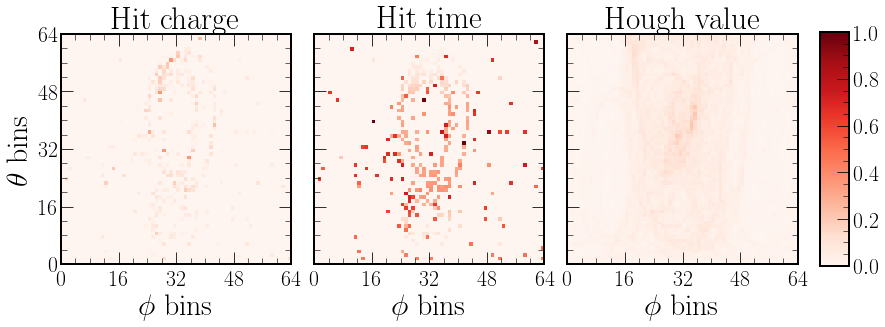

In [28]:
event_num = 1045
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_nuel_ncdis_event")

3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


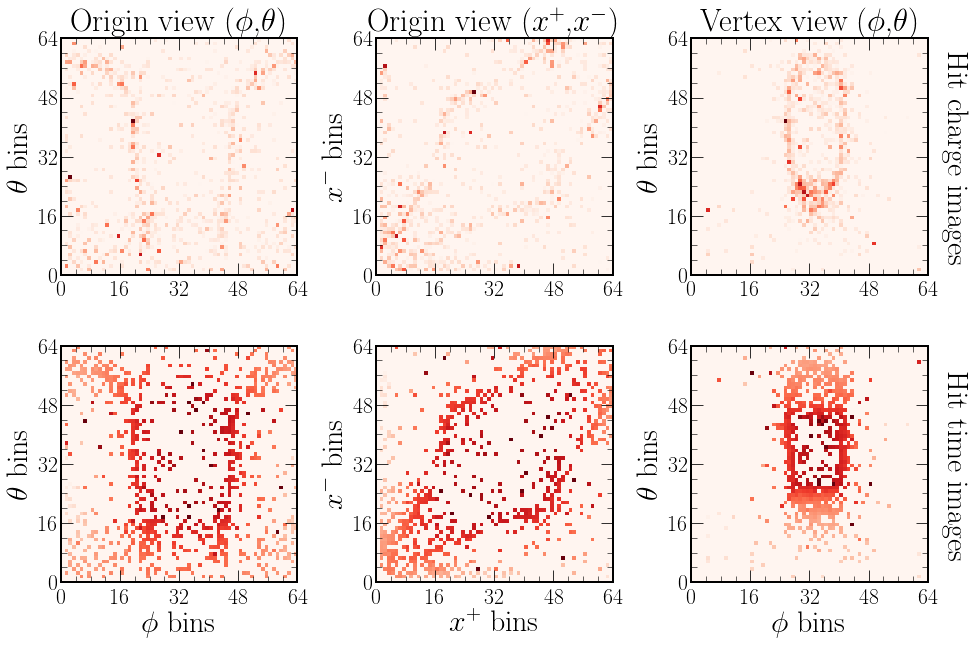

In [29]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_repr_nuel_ccres_event")

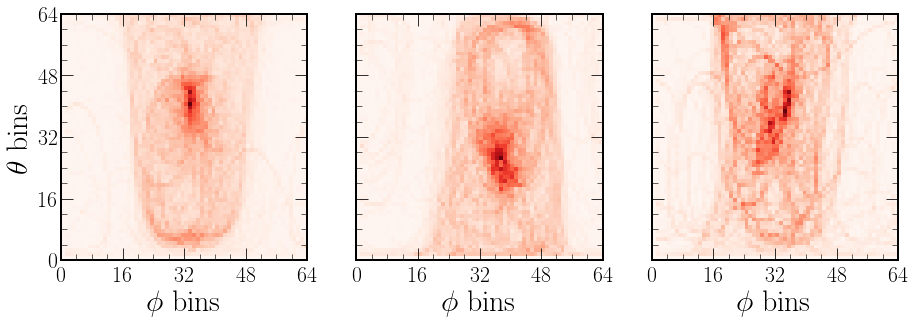

In [30]:
chipsnet.plotting.plot_hough(images_dict, [1009, 2014, 1045], save_path+"explore_hough_events")

[0,25], outside range: 0.0010
[0,120], outside range: 0.0015
[0,3500], outside range: 0.0023


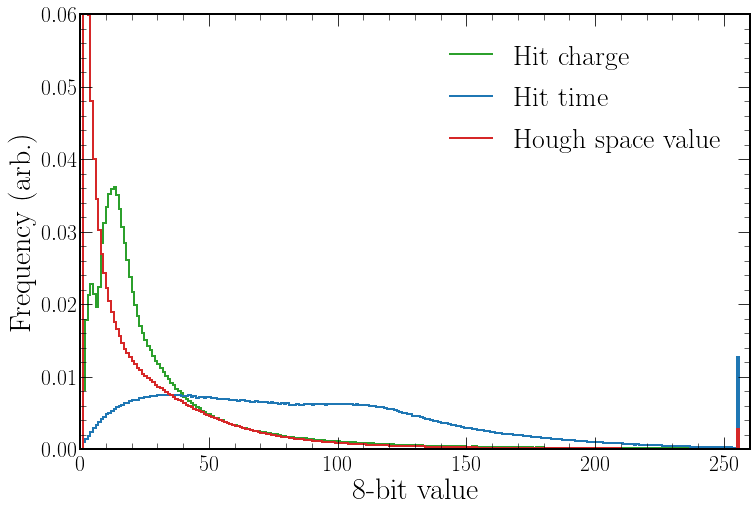

In [25]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

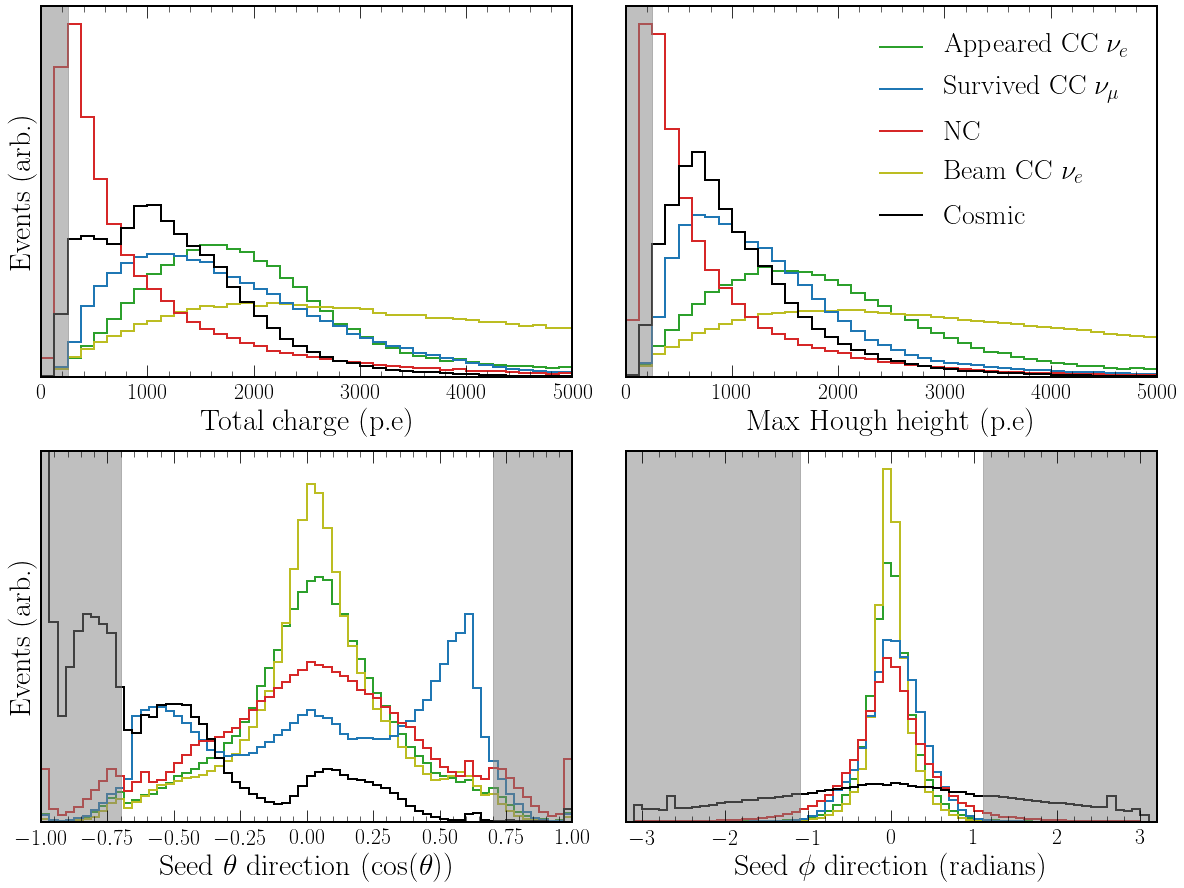

In [5]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [ ]:
# Tidy up
del s_both_ev, s_both_out
del s_flux_ev, s_flux_out
del s_uniform_ev, s_uniform_out
del flux_ev, flux_out
del images_dict
del numu_ev, nuel_ev, osc_nuel_ev

<a id='sample'></a>

## Which training sample is best? (sample)
* The training sample used has a significant impact on performance.
* This is due to both the ratio of the different number of events and the energy distribution of them
* Using the expected beam flux as expected has the best performance for then evaluating the beam flux

In [4]:
ev, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_all_cat", "t_all_cat", "t_all_cat"]
)


************************ Evaluating flux ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ sample_both report ------------------------
- Comb-> Prec: (0.93986,0.69922), Rec: (0.90417,0.86362), F1: (0.91708,0.73936)
- Cat->  Prec: (0.58624,0.33928), Rec: (0.49474,0.43360), F1: (0.50887,0.30761)

- Nuel-> ROC-AUC: 0.82063, PRC-AUC: 0.63433, S-Eff: 0.83419, S-Pur: 0.36825
- FOM1-> 0.38641, 0.84500, 52.19236, 19.00772, 17.81696, 0.65904, 0.58632
- FOM2-> 10.10740, 0.96000, 30.52458, 4.49055, 4.62998, 0.38544, 0.76995

- Numu-> ROC-AUC: 0.66439, PRC-AUC: 0.92134, S-Eff: 0.85415, S-Pur: 0.99374
- FOM1-> 0.87119, 0.11000, 3.99567, 1832.73827, 46.30107, 0.89510, 0.97329
- FOM2-> 2162.31651, 0.99500, 0.02434, 1409.12000, 0.40033, 0.68821, 0.99970


------------------------ sample_flux report ------------------------
- Comb-> Prec: (0.9447

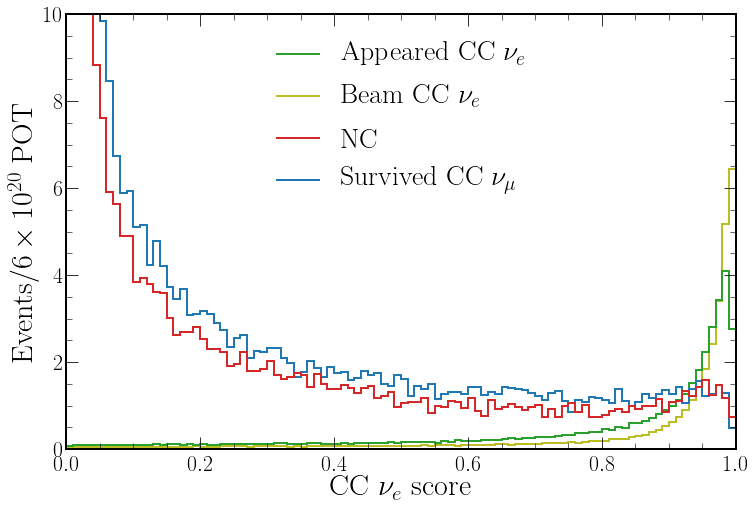

In [5]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_both_", save_path+"sample_both_output_values")

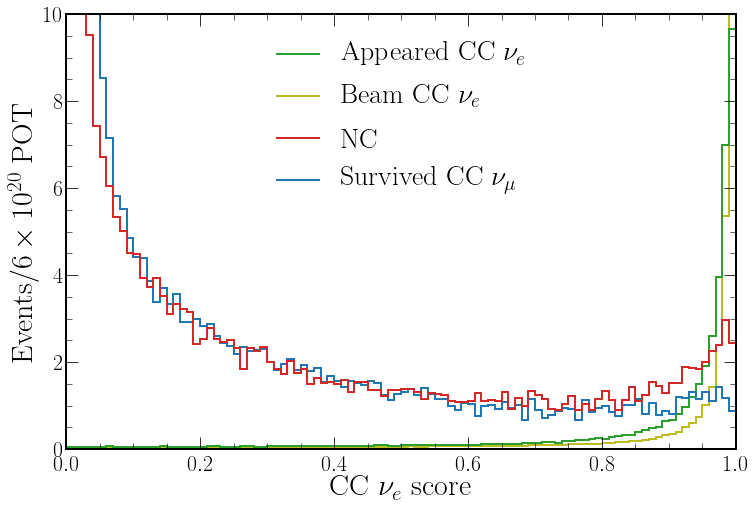

In [6]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_flux_", save_path+"sample_flux_output_values")

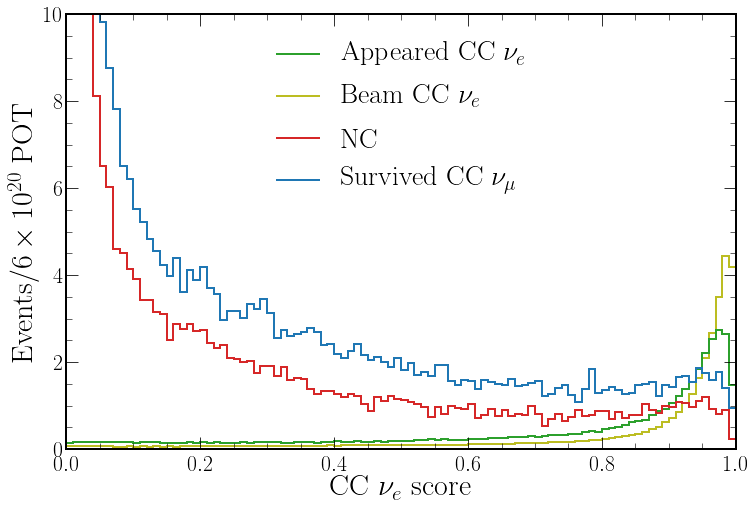

In [7]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_uniform_", save_path+"sample_uniform_output_values")

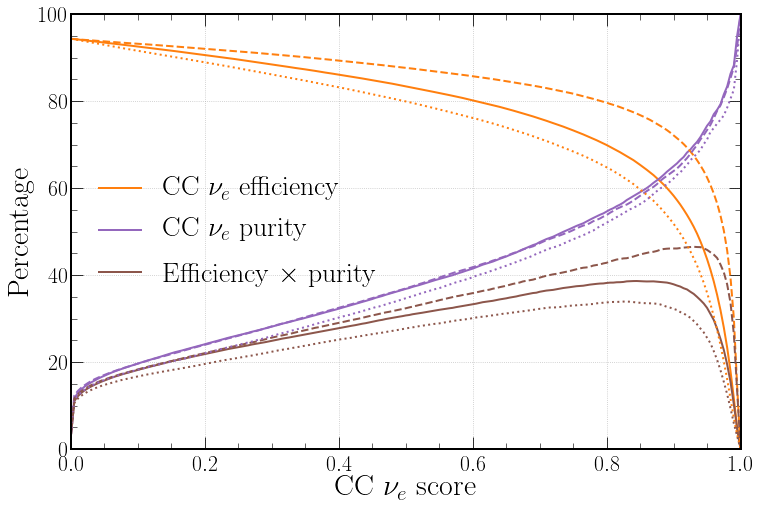

In [8]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_eff_curves")

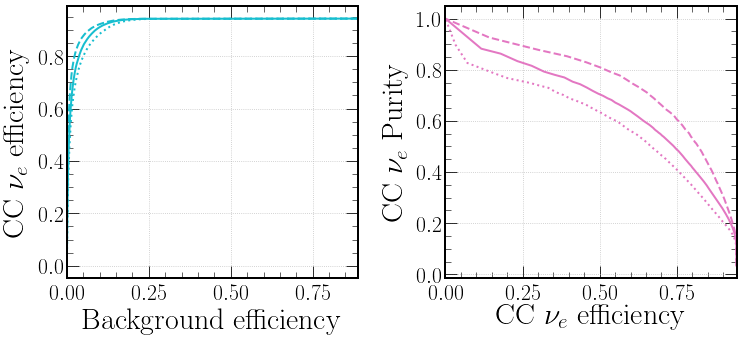

In [9]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"sample_nuel_comp_curves")

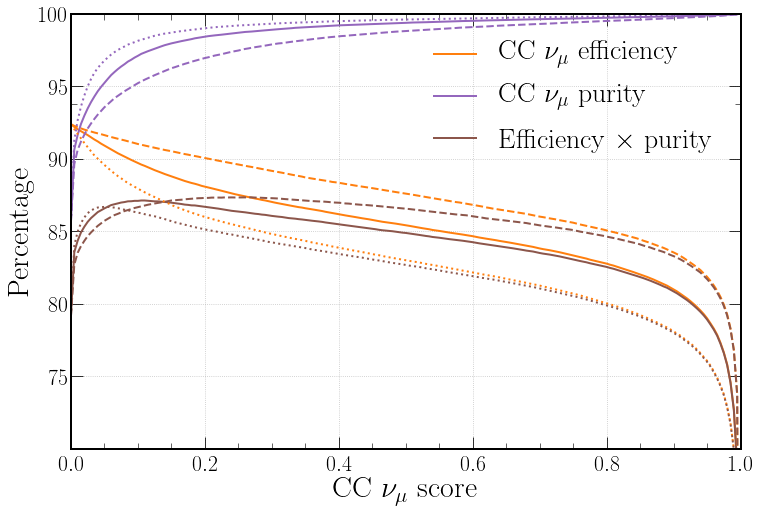

In [10]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_eff_curves")

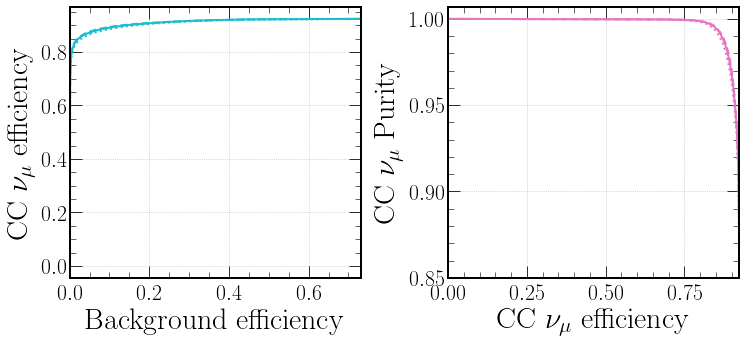

In [11]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"sample_numu_comp_curves")

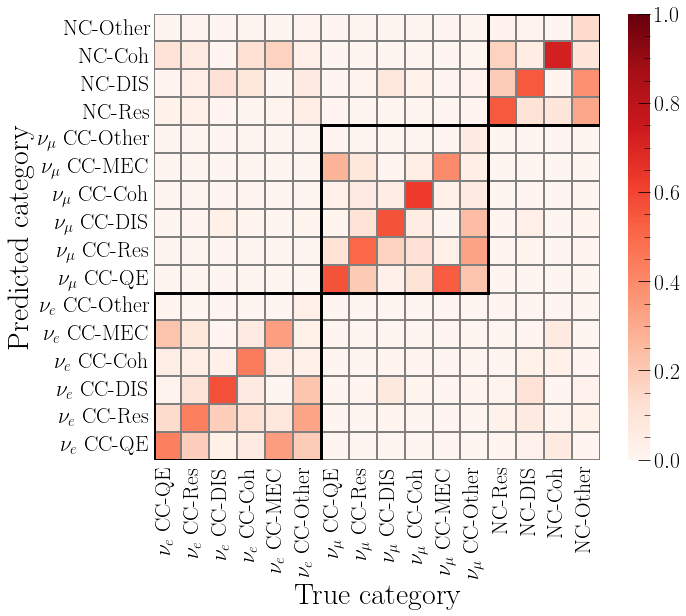

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

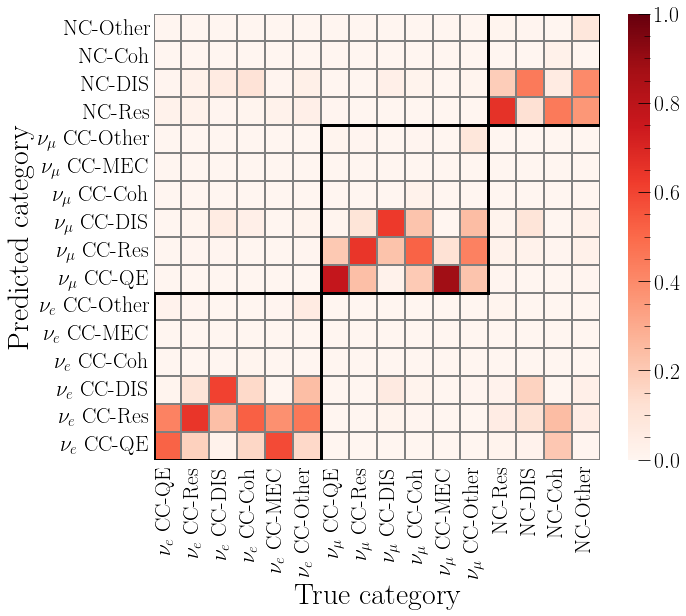

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

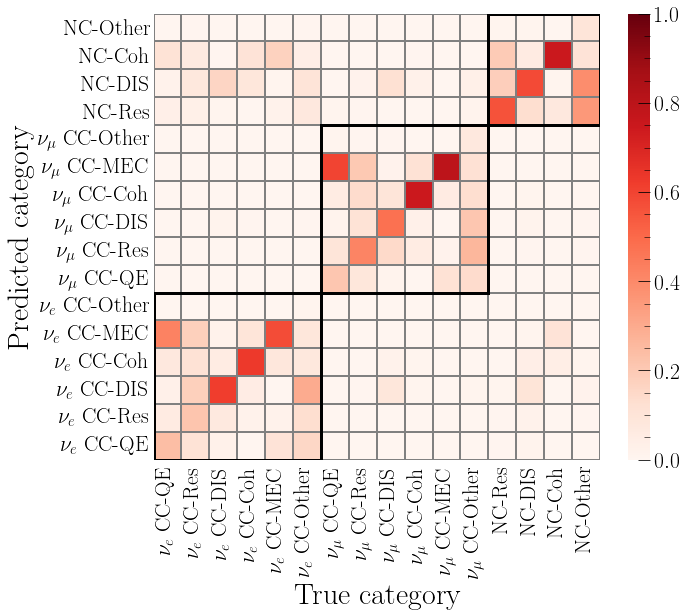

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [12]:
# Tidy up
del outputs

<a id='repr'></a>

## Which image representation is best? (repr)
* The theta/phi representation as viewed from the roughly reconstructed interaction vertex is clearly the best
* It performs better on every performance metric
* This is definitely due to the way it standardises the input events, so they are scaled/viewed correctly and the different shapes can more easily be identified.

In [13]:
v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Vertex theta/phi repr
o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_all_cat"], just_out=True)  # Origin theta/phi repr
i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_all_cat"], just_out=True)  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94500,0.71822), Rec: (0.90758,0.85193), F1: (0.91984,0.73188)
- Cat->  Prec: (0.58101,0.35860), Rec: (0.55903,0.32610), F1: (0.54128,0.27742)

- Nuel-> ROC-AUC: 0.82510, PRC-AUC: 0.70690, S-Eff: 0.87786, S-Pur: 0.35432
- FOM1-> 0.46118, 0.93000, 52.98773, 8.61419, 15.27358, 0.66908, 0.68927
- FOM2-> 13.28234, 0.98500, 29.73833, 1.42622, 3.58663, 0.37551, 0.85575

- Numu-> ROC-AUC: 0.66452, PRC-AUC: 0.92136, S-Eff: 0.87095, S-Pur: 0.98952
- FOM1-> 0.87257, 0.21500, 3.47276, 1832.94828, 44.07139, 0.89520, 0.97472
- FOM2-> 1808.04447, 0.99500, 0.02799, 1479.22294, 0.64136, 0.72244, 0.99955

took 551.90 seconds

************************ Evaluating o_ct_flux ************************
Loading best checkpoint (11)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501601,0.96051), (330186,0.93136), (102603,0.69676), (0,0.00000)

------------------------ repr_o_ct report ------------------------
- Comb-> Prec: (0.93960,0.68550), Rec: (0.88352,0.83977), F1: (0.90367,0.69789)
- Cat->  Prec: (0.56412,0.33568), Rec: (0.54305,0.32486), F1: (0.53147,0.26957)

- Nuel-> ROC-AUC: 0.82178, PRC-AUC: 0.67476, S-Eff: 0.87440, S-Pur: 0.29110
- FOM1-> 0.42211, 0.95500, 50.65699, 10.25741, 15.82969, 0.63949, 0.66008
- FOM2-> 12.50722, 0.99000, 29.40964, 1.76920, 3.75994, 0.37126, 0.84175

- Numu-> ROC-AUC: 0.66254, PRC-AUC: 0.92044, S-Eff: 0.84324, S-Pur: 0.99148
- FOM1-> 0.86223, 0.11500, 6.16244, 1839.28237, 67.99253, 0.89699, 0.96125
- FOM2-> 1719.79760, 0.99500, 0.04092, 1443.39743, 0.66348, 0.70392, 0.99951

took 1141.37 seconds

************************ Evaluating i_ct_flux ************************
Loading best checkpoint (11)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501601,0.96051), (330186,0.93136), (102603,0.69676), (0,0.00000)

------------------------ repr_i_ct report ------------------------
- Comb-> Prec: (0.94022,0.69018), Rec: (0.88540,0.83617), F1: (0.90486,0.69869)
- Cat->  Prec: (0.56507,0.34165), Rec: (0.54372,0.32068), F1: (0.53123,0.26846)

- Nuel-> ROC-AUC: 0.82116, PRC-AUC: 0.66988, S-Eff: 0.86661, S-Pur: 0.29765
- FOM1-> 0.41903, 0.94500, 50.97448, 10.84828, 16.45768, 0.64350, 0.65118
- FOM2-> 12.22842, 0.99000, 28.43970, 1.74364, 3.66526, 0.35902, 0.84020

- Numu-> ROC-AUC: 0.66213, PRC-AUC: 0.92035, S-Eff: 0.84607, S-Pur: 0.99032
- FOM1-> 0.86023, 0.16000, 5.98284, 1833.78831, 66.67471, 0.89431, 0.96189
- FOM2-> 1931.89209, 0.99500, 0.03651, 1424.95417, 0.50753, 0.69493, 0.99962

took 549.32 seconds


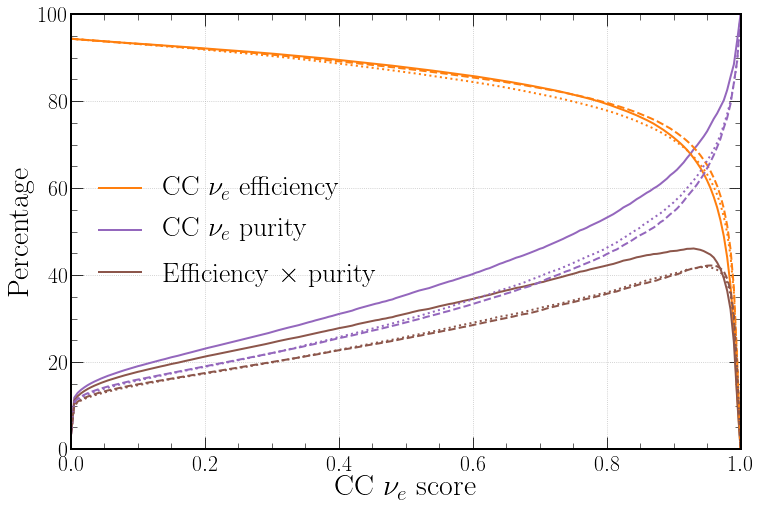

In [14]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_eff_curves")

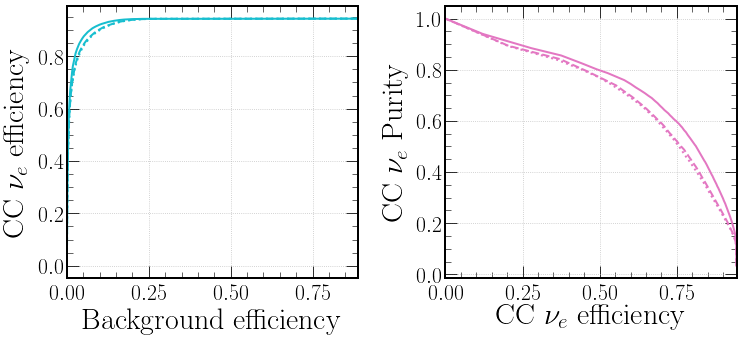

In [15]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_comp_curves")

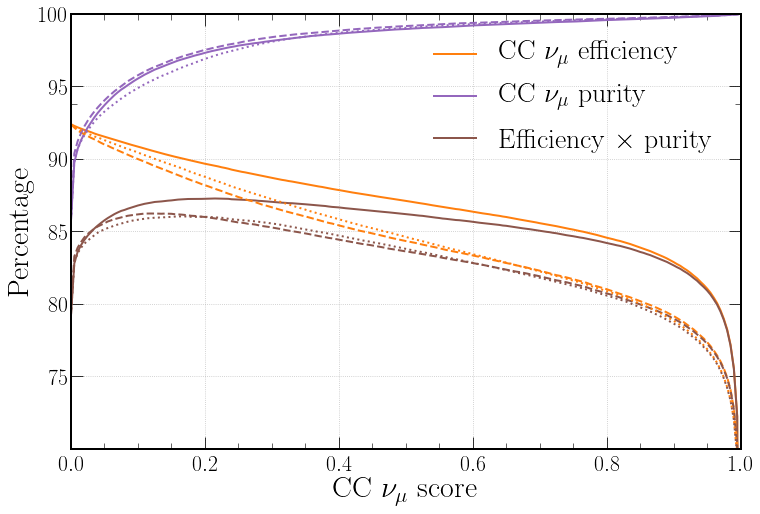

In [16]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_eff_curves")

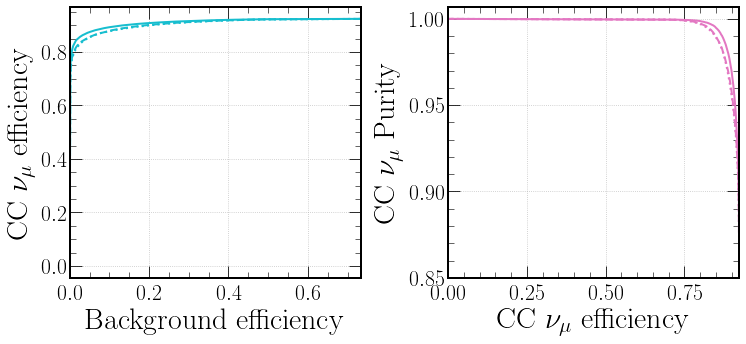

In [17]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_comp_curves")

In [18]:
# Tidy up
del v_out
del o_out
del i_out

<a id='arch'></a>

## Which network architecture works best?
* VGG is the best with inception trailing in second
* It is likely that the others can have their hyperparameters optimised

In [19]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["arch_vgg", "arch_inception", "arch_resnet", "arch_inception_resnet"],
    ["t_all_cat", "t_all_cat", "t_all_cat", "t_all_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (7)
Loading best checkpoint (6)
Loading best checkpoint (8)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ arch_vgg report ------------------------
- Comb-> Prec: (0.94475,0.72482), Rec: (0.91101,0.85060), F1: (0.92157,0.73694)
- Cat->  Prec: (0.58295,0.37149), Rec: (0.56387,0.32640), F1: (0.54439,0.27883)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87660, S-Pur: 0.36926
- FOM1-> 0.46511, 0.93000, 53.44508, 8.34639, 15.75517, 0.67486, 0.68920
- FOM2-> 13.44671, 0.98500, 31.21725, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87598, S-Pur: 0.98808
- FOM1-> 0.87339, 0.25500, 3.22962, 1833.69093, 43.33464, 0.89556, 0.97524
- FOM2-> 1850.91139, 0.99500, 0.03552, 1509.61983, 0.62970, 0.73729, 0.99956


------------------------ arch_inception report --------------------

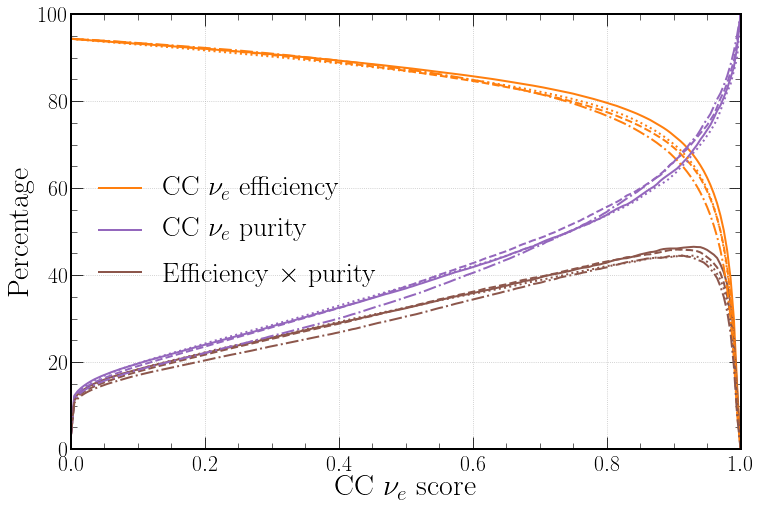

In [20]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_eff_curves")

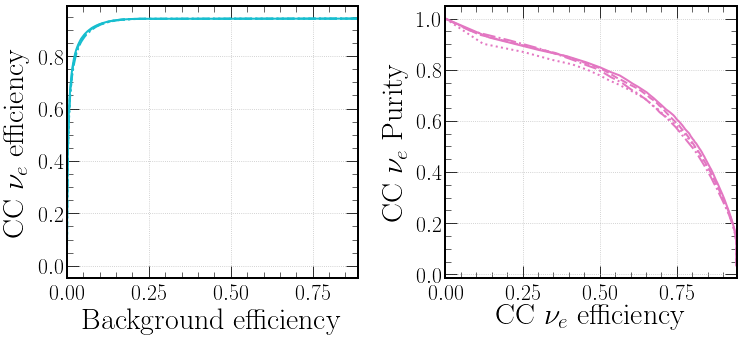

In [21]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_comp_curves")

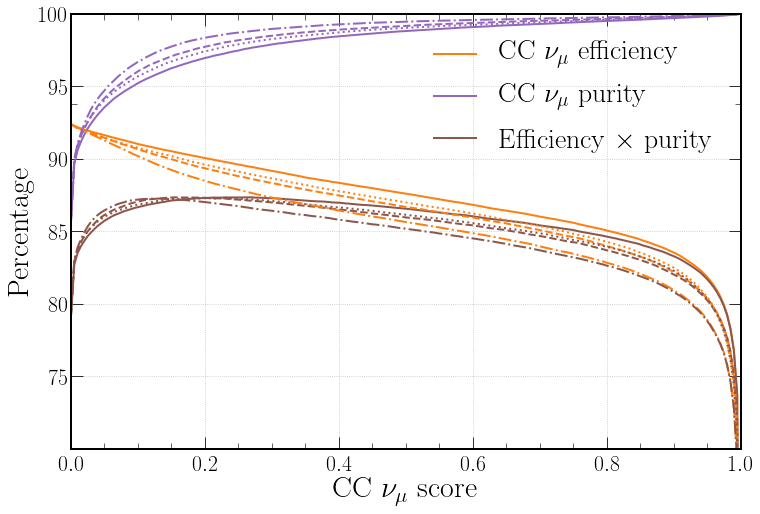

In [22]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_eff_curves")

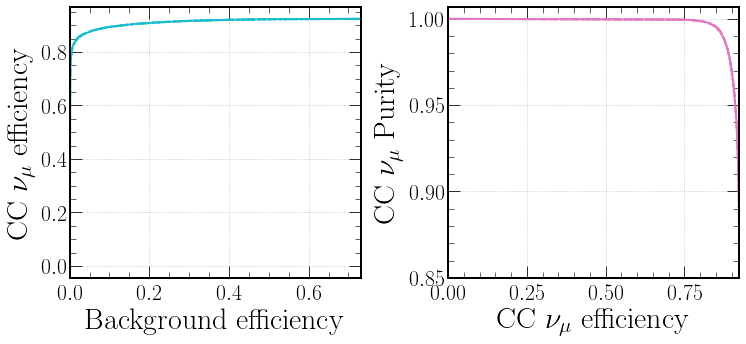

In [23]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_comp_curves")

In [24]:
# Tidy up
del outputs

<a id='channel'></a>

## Which channel configuration is best? (channel)
* The differences are much smaller than you would expect given the extra info you would think the extra channels provide
* Overall having all three channels together does make a difference
* It also is much better to have the seperate stems for each channel rather than using a single 3 channel image

In [4]:
c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_all_cat"], just_out=True)  # Just charge channel
ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Charge+time channels
cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels
cth_stacked_out = chipsnet.utils.evaluate(config, "v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.94304,0.71334), Rec: (0.90703,0.85439), F1: (0.91928,0.73422)
- Cat->  Prec: (0.57348,0.35221), Rec: (0.54850,0.31747), F1: (0.52990,0.27058)

- Nuel-> ROC-AUC: 0.82377, PRC-AUC: 0.68936, S-Eff: 0.86860, S-Pur: 0.35675
- FOM1-> 0.43608, 0.91000, 53.71033, 12.22704, 17.59424, 0.67821, 0.64299
- FOM2-> 12.70511, 0.99000, 20.74129, 0.76294, 1.90217, 0.26190, 0.88614

- Numu-> ROC-AUC: 0.66320, PRC-AUC: 0.92108, S-Eff: 0.86814, S-Pur: 0.98982
- FOM1-> 0.86820, 0.20500, 3.47053, 1825.09956, 45.22359, 0.89137, 0.97401
- FOM2-> 1781.73137, 0.99500, 0.05013, 1510.25853, 0.66836, 0.73760, 0.99952

took 492.49 seconds

************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94500,0.71822), Rec: (0.90758,0.85193), F1: (0.91983,0.73188)
- Cat->  Prec: (0.58101,0.35858), Rec: (0.55904,0.32611), F1: (0.54129,0.27741)

- Nuel-> ROC-AUC: 0.82509, PRC-AUC: 0.70690, S-Eff: 0.87787, S-Pur: 0.35433
- FOM1-> 0.46117, 0.93000, 52.98732, 8.61419, 15.27357, 0.66908, 0.68927
- FOM2-> 13.28324, 0.98500, 29.74037, 1.42622, 3.58663, 0.37553, 0.85576

- Numu-> ROC-AUC: 0.66452, PRC-AUC: 0.92136, S-Eff: 0.87096, S-Pur: 0.98952
- FOM1-> 0.87257, 0.21500, 3.47328, 1832.94828, 44.07104, 0.89520, 0.97472
- FOM2-> 1808.02009, 0.99500, 0.02799, 1479.20299, 0.64136, 0.72243, 0.99955

took 522.46 seconds

************************ Evaluating v_cth_flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_cth report ------------------------
- Comb-> Prec: (0.94475,0.72482), Rec: (0.91101,0.85060), F1: (0.92157,0.73694)
- Cat->  Prec: (0.58298,0.37149), Rec: (0.56389,0.32640), F1: (0.54442,0.27884)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36926
- FOM1-> 0.46502, 0.93000, 53.44466, 8.36064, 15.75486, 0.67485, 0.68907
- FOM2-> 13.44660, 0.98500, 31.21698, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87597, S-Pur: 0.98808
- FOM1-> 0.87339, 0.25500, 3.22958, 1833.71393, 43.34867, 0.89558, 0.97523
- FOM2-> 1850.91122, 0.99500, 0.03552, 1509.61970, 0.62970, 0.73729, 0.99956

took 555.01 seconds

************************ Evaluating v_cth_flux_stacked ************************
Loading best checkpoint (9)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_cth_stacked report ------------------------
- Comb-> Prec: (0.94595,0.72742), Rec: (0.91607,0.86280), F1: (0.92595,0.75097)
- Cat->  Prec: (0.58567,0.36214), Rec: (0.56944,0.33509), F1: (0.55087,0.29105)

- Nuel-> ROC-AUC: 0.82521, PRC-AUC: 0.70200, S-Eff: 0.87178, S-Pur: 0.38254
- FOM1-> 0.45836, 0.91500, 55.18735, 11.55275, 17.16238, 0.69686, 0.65776
- FOM2-> 12.66459, 0.99000, 24.37773, 1.35104, 2.35409, 0.30782, 0.86806

- Numu-> ROC-AUC: 0.66522, PRC-AUC: 0.92153, S-Eff: 0.87580, S-Pur: 0.98999
- FOM1-> 0.87560, 0.21000, 3.17742, 1834.92672, 39.91415, 0.89617, 0.97705
- FOM2-> 1689.15661, 0.99500, 0.06176, 1540.31737, 0.76977, 0.75228, 0.99946

took 502.26 seconds


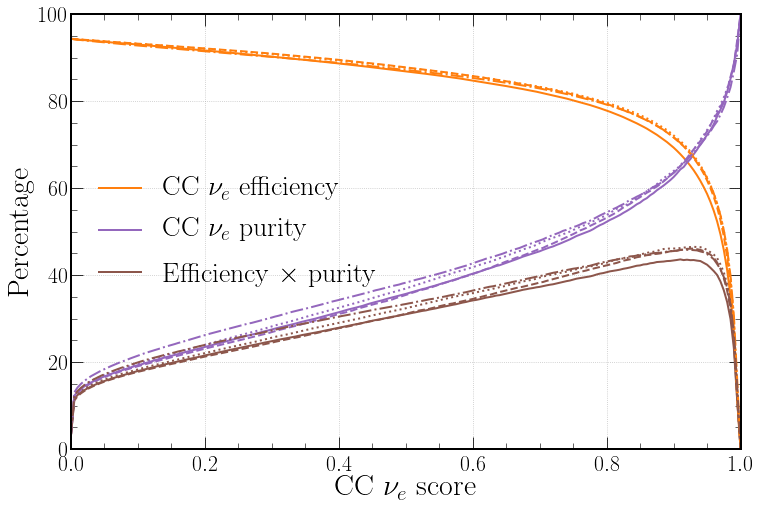

In [5]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_eff_curves")

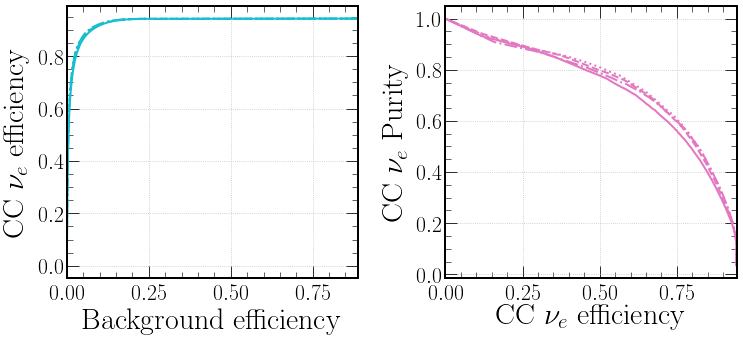

In [6]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_comp_curves")

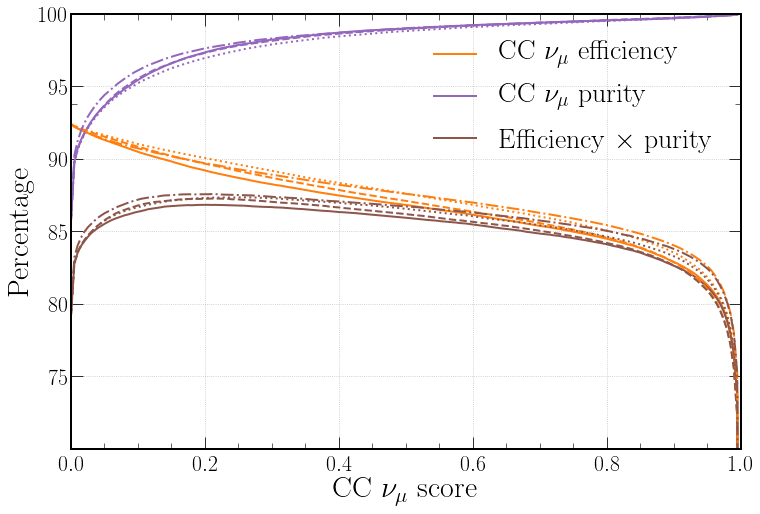

In [7]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_eff_curves")

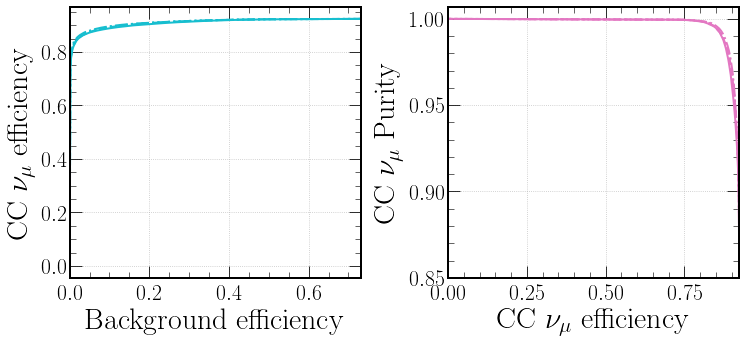

In [8]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_comp_curves")

In [9]:
# Tidy up
del c_out
del ct_out
del cth_out
del cth_stacked_out

<a id='cat'></a>

## Which categorisation is best? (cat)
* It looks like the split learner using ["t_comb_cat", "t_cc_type", "t_nc_type"] is the best, but by an almost negligble difference
* Still need to look at how well it splits apart to cc and nc types for full analysis
* A close second is then "t_all_cat" this is still reasonable to use to simplify other studies

In [10]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_all_cat", "cat_t_nc_comb_cat", "cat_t_comb_cat", "cat_split", "cat_split_learn"], 
    ["t_all_cat", "t_nc_comb_cat", "t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (7)
Loading best checkpoint (5)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ cat_t_all_cat report ------------------------
- Comb-> Prec: (0.94475,0.72482), Rec: (0.91101,0.85060), F1: (0.92157,0.73694)
- Cat->  Prec: (0.58298,0.37149), Rec: (0.56389,0.32640), F1: (0.54442,0.27884)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36926
- FOM1-> 0.46502, 0.93000, 53.44466, 8.36064, 15.75486, 0.67485, 0.68907
- FOM2-> 13.44660, 0.98500, 31.21698, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87597, S-Pur: 0.98808
- FOM1-> 0.87339, 0.25500, 3.22958, 1833.71393, 43.34867, 0.89558, 0.97523
- FOM2-> 1850.91122, 0.99500, 0.03552, 1509.61970, 0.62970, 0.73729, 0.99956


------------------------ cat_t_nc_

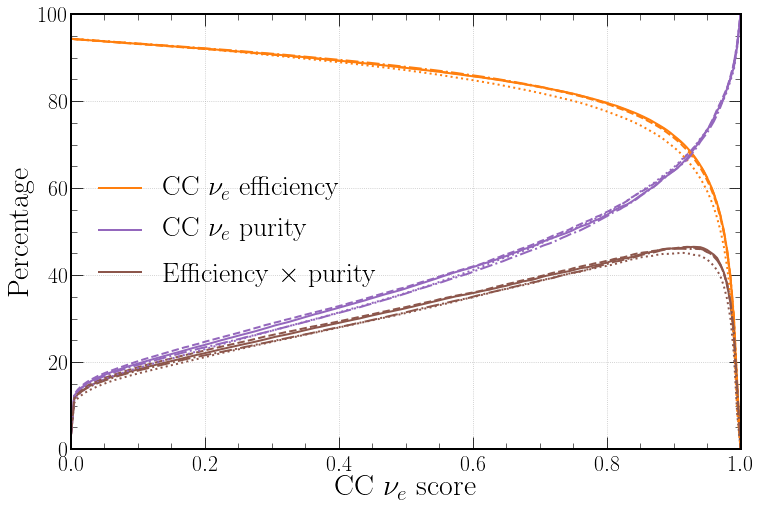

In [11]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_eff_curves")

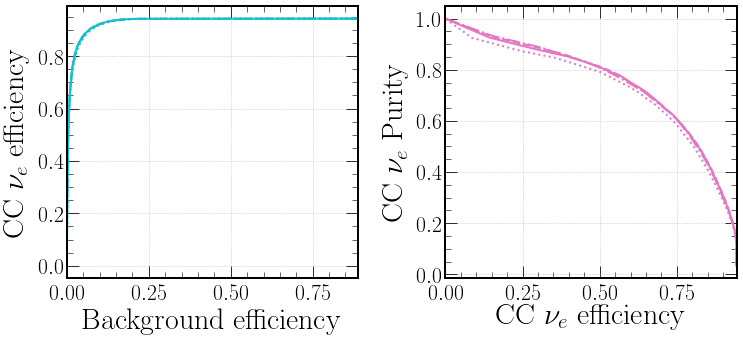

In [12]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_comp_curves")

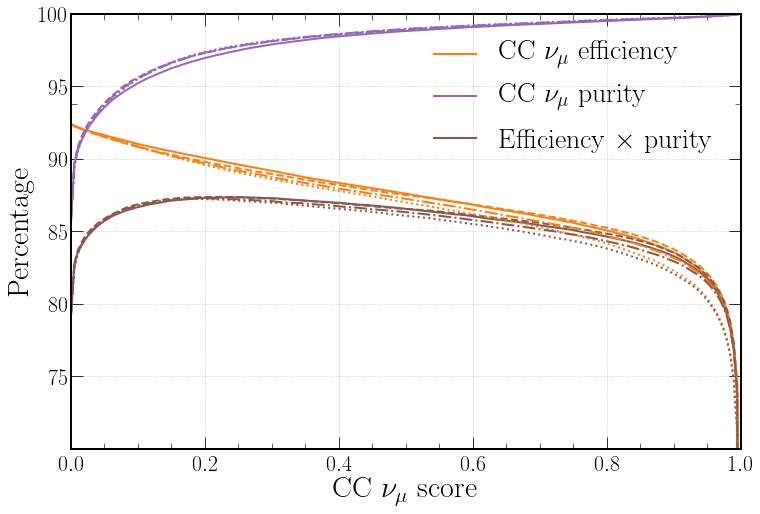

In [13]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_eff_curves")

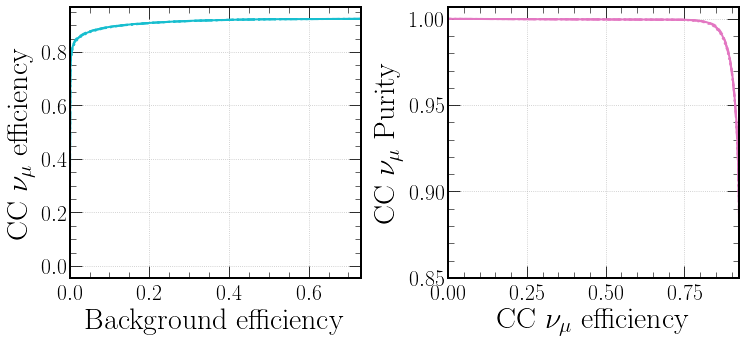

In [14]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_comp_curves")

In [15]:
# Tidy up
del outputs

<a id='cosmic'></a>

## Does escapes help cosmic classifier? (cosmic)
* Looks like the single t_cosmic_cat classifier and the learned + t_escapes are the best
* Looks like the events that do pass are mainly classified as NC which is good
* Need to do a final evaluation with the complete final beam model to make sure

In [64]:
ev, out = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_e, out_e = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_el, out_el = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes_learn"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)


************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    3.527680e+05
mean     9.992678e-01
std      1.917471e-02
min      2.661729e-10
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (5,0.00001)
took 209.44 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (3)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    352768.000000
mean          0.998948
std           0.020130
min           0.000795
25%           0.999990
50%           0.999999
75%           1.000000
max           1.000000
Name: cosmic_escapes_pred_t_cosmic_cat, dtype: float64
count    263384.000000
mean          0.914934
std           0.091285
min           0.000227
25%           0.869715
50%           0.939248
75%           0.987616
max           0.999991
Name: cosmic_escapes_pred_t_escapes, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
took 215.11 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (15)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,3.43199)
count    352768.000000
mean          0.999820
std           0.011252
min           0.000006
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: cosmic_escapes_learn_pred_t_cosmic_cat, dtype: float64
count    263384.000000
mean          0.922769
std           0.104116
min           0.000098
25%           0.888178
50%           0.962673
75%           0.994820
max           1.000000
Name: cosmic_escapes_learn_pred_t_escapes, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (2,0.00001)
took 213.45 seconds


In [65]:
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 4.81871599e-02 7.38256821e-04 3.43030109e-03
 1.62112589e-06]
[0.99998447 0.69523085 0.82561696 0.9636501  0.9999724 ]
[1.39880872e-05 2.56581931e-01 1.73644805e-01 3.29195743e-02
 2.60208206e-05]
[1 1 1 1 1]


In [66]:
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[]
[]
[]
[]


In [67]:
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 5.87562063e-04]
[0.99998447 0.99702819]
[1.39880872e-05 2.38418037e-03]
[1 1]


In [68]:
# Tidy up
del ev, out
del ev_e, out_e
del ev_el, out_el

<a id='beam'></a>

## Does primary count help beam classifier? (beam)
* Yes it does help, not a huge effect but it definitely add something, which makes sense.
* The not learned version of the multitask weights seems to work best.

In [69]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (6)
Loading best checkpoint (4)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ beam report ------------------------
- Comb-> Prec: (0.94460,0.73392), Rec: (0.91711,0.85569), F1: (0.92553,0.75106)
- Cat->  Prec: (0.94460,0.73392), Rec: (0.91711,0.85569), F1: (0.92553,0.75106)

- Nuel-> ROC-AUC: 0.82578, PRC-AUC: 0.71645, S-Eff: 0.87190, S-Pur: 0.39323
- FOM1-> 0.47189, 0.92500, 54.78695, 9.24055, 16.29189, 0.69180, 0.68211
- FOM2-> 13.51890, 0.99000, 25.59982, 1.11573, 2.47011, 0.32325, 0.87714

- Numu-> ROC-AUC: 0.66495, PRC-AUC: 0.92146, S-Eff: 0.88081, S-Pur: 0.98647
- FOM1-> 0.87414, 0.21500, 3.82185, 1843.35250, 51.30760, 0.90028, 0.97096
- FOM2-> 1677.53044, 0.99500, 0.05181, 1534.41219, 0.78484, 0.74940, 0.99946


------------------------ beam_primaries report ------------------------
- Comb-> Prec: (0.94566,0.7

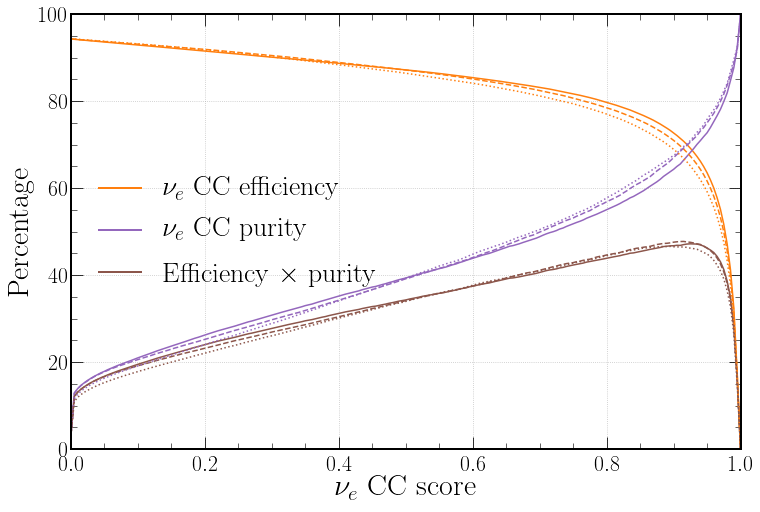

In [70]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_eff_curves")

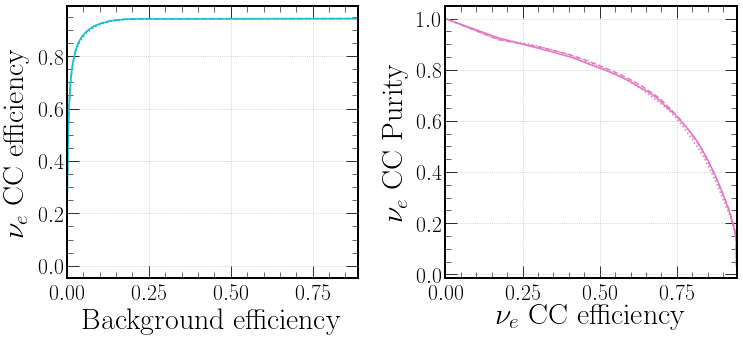

In [71]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_comp_curves")

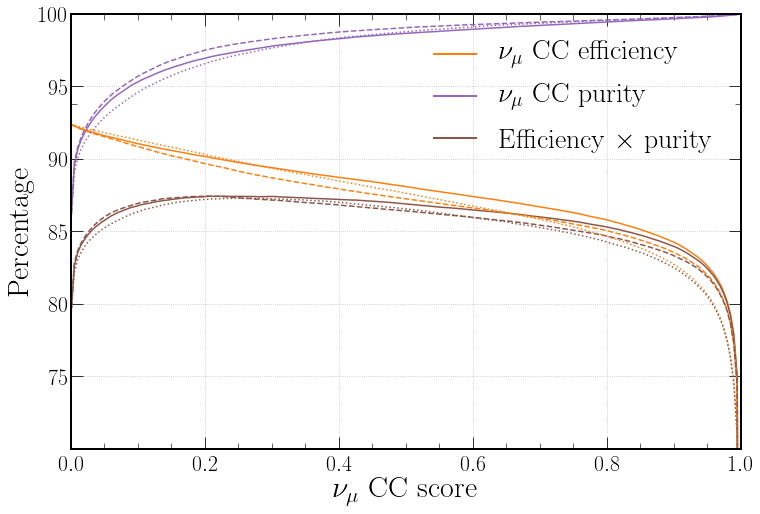

In [72]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_eff_curves")

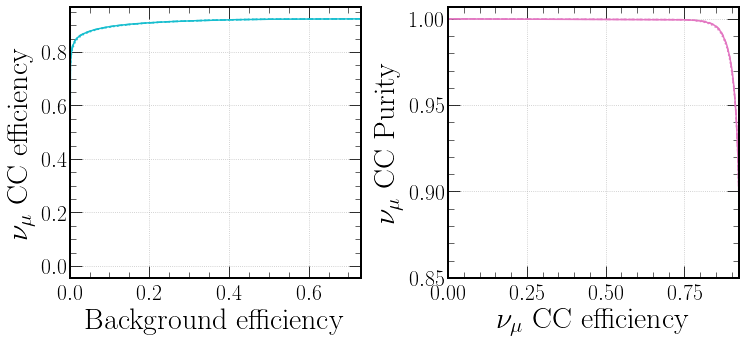

In [73]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_comp_curves")

In [74]:
# Tidy up
del outputs

<a id='energy_multi'></a>

## Does lepton energy and vertex position help neutrino energy estimation? (energy_multi)
* There doesn't seem to be a noticable difference when both are trained together
* This has only been testing on nuel cc, it may be different for numu cc
* As its negligable we will train together using the learned approach as that seems best

In [4]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_ccqel",
    ["energy_nu", "energy_lep", "energy_nu_lep", "energy_nu_lep_learn", "energy_nu_lep_vtx", "energy_nu_lep_vtx_learn"],
    ["energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_ccqel ************************
Loading best checkpoint (11)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (18)
Loading best checkpoint (11)
Loading best checkpoint (17)
Loading best checkpoint (7)
Loading best checkpoint (19)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
Cuts:    (62357,0.97433), (0,0.00000), (0,0.00000), (0,0.00000)
took 109.88 seconds


In [5]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

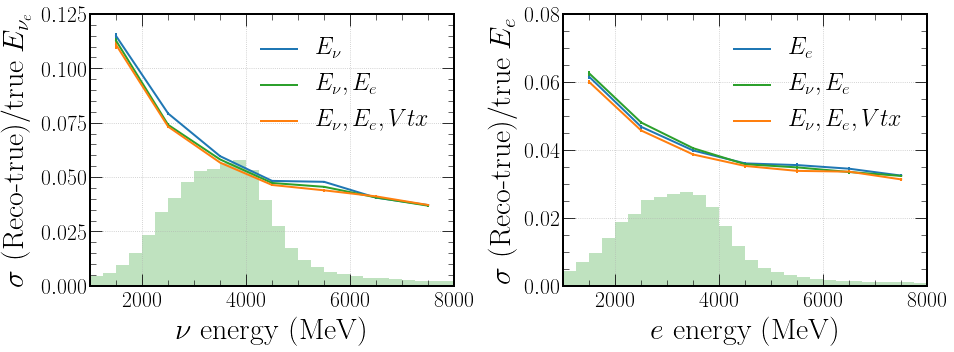

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_nu_energy")
axs[0].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange", linewidth=2)
axs[0].set_xlabel(r"$\nu$ energy (MeV)", fontsize=30)
axs[0].set_ylabel(r"$\sigma$ (Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylim(0.0, 0.125)
axs[0].set_xlim(1000, 8000)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:blue", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:green", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list, std_list[0], yerr=std_list[1], color="tab:orange", linewidth=2)
axs[1].set_xlabel(r"$e$ energy (MeV)", fontsize=30)
axs[1].set_ylabel(r"$\sigma$ (Reco-true)/true $E_{e}$", fontsize=30)
axs[1].set_ylim(0.0, 0.08)
axs[1].set_xlim(1000, 8000)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"],
    range=(1000, 8000),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.000005,
)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
nu_lep_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e}$")
nu_lep_vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e},Vtx$")
axs[0].legend(handles=[nu, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)
axs[1].legend(handles=[lep, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "energy_multi_frac_vs_e")

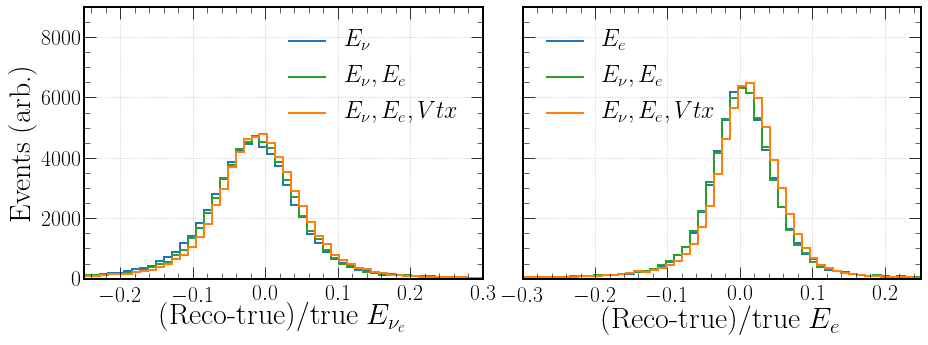

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:blue", linewidth=2
)
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:green", linewidth=2
)
axs[0].hist(
    ev['energy_nu_lep_vtx_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:orange", linewidth=2
)
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30) 
axs[0].set_ylabel(r"Events (arb.)", fontsize=30)
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 9000)
axs[1].hist(
    ev['energy_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:blue", linewidth=2
)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:green", linewidth=2
)
axs[1].hist(
    ev['energy_nu_lep_vtx_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:orange", linewidth=2
)
axs[1].set_xlabel(r"(Reco-true)/true $E_{e}$", fontsize=30)
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 9000)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
nu_lep_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e}$")
nu_lep_vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e},Vtx$")
axs[0].legend(handles=[nu, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)
axs[1].legend(handles=[lep, nu_lep_learn, nu_lep_vtx_learn], loc="upper left", fontsize=24)

chipsnet.plotting.save(save_path + "energy_multi_frac_dist")

In [8]:
print(ev['energy_nu_frac_nu_energy'].describe())
print(ev['energy_nu_lep_frac_nu_energy'].describe())
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_nu_energy'].describe())

count    62125.000000
mean        -0.017884
std          0.089801
min         -0.718726
25%         -0.059492
50%         -0.017418
75%          0.022659
max          2.810825
Name: energy_nu_frac_nu_energy, dtype: float64
count    62125.000000
mean        -0.016636
std          0.089786
min         -0.717637
25%         -0.058581
50%         -0.018781
75%          0.021507
max          2.906162
Name: energy_nu_lep_frac_nu_energy, dtype: float64
count    62125.000000
mean        -0.013222
std          0.088281
min         -0.704580
25%         -0.054374
50%         -0.013975
75%          0.025765
max          3.202766
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64
count    62125.000000
mean        -0.012822
std          0.092249
min         -0.726886
25%         -0.055923
50%         -0.015520
75%          0.026428
max          3.009444
Name: energy_nu_lep_vtx_frac_nu_energy, dtype: float64
count    62125.000000
mean        -0.009205
std          0.085784
min         -0.72647

In [9]:
print(ev['energy_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_lep_energy'].describe())

count    62125.000000
mean         0.005134
std          0.094893
min         -0.734775
25%         -0.026275
50%          0.003162
75%          0.033024
max          4.534911
Name: energy_lep_frac_lep_energy, dtype: float64
count    62125.000000
mean         0.002718
std          0.095859
min         -0.728223
25%         -0.030221
50%          0.000338
75%          0.030943
max          4.760154
Name: energy_nu_lep_frac_lep_energy, dtype: float64
count    62125.000000
mean         0.004141
std          0.092994
min         -0.727647
25%         -0.027176
50%          0.002942
75%          0.032754
max          4.889477
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64
count    62125.000000
mean        -0.003939
std          0.100383
min         -0.744467
25%         -0.038228
50%         -0.006529
75%          0.025228
max          4.545616
Name: energy_nu_lep_vtx_frac_lep_energy, dtype: float64
count    62125.000000
mean         0.009097
std          0.090235
min         -0.

In [63]:
# Tidy up
del events, outputs, ev

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)

In [7]:
# Run analysis through all the final models
events, outputs = chipsnet.utils.evaluate(
    config, "flux_cosmic", 
    ["final_cosmic", "final_beam", "final_nuel_cc_e", "final_numu_cc_e",
     "final_nuel_ccdis_e", "final_nuel_ccqel_e", "final_nuel_ccres_e",
     "final_numu_ccdis_e", "final_numu_ccqel_e", "final_numu_ccres_e"],
    ["t_cosmic_cat", "t_comb_cat", "energy", "energy",
     "energy", "energy", "energy",
     "energy", "energy", "energy"]
)


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Loading best checkpoint (7)
Loading best checkpoint (19)
Loading best checkpoint (10)
Loading best checkpoint (19)
Loading best checkpoint (16)
Loading best checkpoint (16)
Loading best checkpoint (11)
Loading best checkpoint (14)
Loading best checkpoint (10)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,4.75840)
count    254434.000000
mean          0.998980
std           0.020888
min           0.000776
25%           0.999993
50%           1.000000
75%           1.000000
max           1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
count    340526.000000
mean          0.938776
std           0.141345
min           0.000004
25%           0.951863
50%           0.991969
75%           0.999019
max           1.000000
Name: final_cosmic_pred_t_escapes, dtype: float64
Cuts:    (391201,0.94774), (87573,0.35725), (75473,0.67592), (0,0.00000)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.99988,0.836

In [8]:
# Get events run through old reco/pid for comparisons
old_events = pd.concat([
    chipsnet.utils.get_old_df(old_nuel_file, 11),
    chipsnet.utils.get_old_df(old_numu_file, 13)
])
old_events = chipsnet.utils.apply_weights(old_events, verbose=True)

Weights: (0,0.00000), (0,0.00000), (23263,0.14414), (0,0.00000), (0,0.00000)


In [9]:
# Apply some standard operations we need throughout this section
def nuel_selected_fom1(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]:
        return True
    else:
        return False
    
def numu_selected_fom1(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_0"][1]:
        return True
    else:
        return False
    
def nuel_selected_fom2(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_1"][0]:
        return True
    else:
        return False
    
def numu_selected_fom2(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_1"][1]:
        return True
    else:
        return False
    
def nc_selected(event):
    if event["cosmic_cut"] == 0 and event["escapes_cut"] == 0 and not event["nuel_selected"] and not event["numu_selected"]:
        return True
    else:
        return False

events["nuel_selected"] = events.apply(nuel_selected_fom1, axis=1)
events["numu_selected"] = events.apply(numu_selected_fom1, axis=1)
events["nuel_selected_2"] = events.apply(nuel_selected_fom2, axis=1)
events["numu_selected_2"] = events.apply(numu_selected_fom2, axis=1)
events["nc_selected"] = events.apply(nc_selected, axis=1)

In [10]:
cosmic_events = events[(events["t_cosmic_cat"] == 1) & (events["simple_cut"] == 1) & (events["escapes_cut"]) & (events["final_cosmic_pred_t_cosmic_cat"] <= 0.9)]
print(cosmic_events["w"].count())
print(cosmic_events["w"].sum())
print(cosmic_events[cosmic_events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]]["w"].sum())
print(cosmic_events[cosmic_events["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_0"][1]]["w"].sum())

38
180.81906843088197
0.0
95.16793075309577


In [11]:
# Classify into CC and NC sub categories
events["final_beam_cc_cat_class"] = events.apply(chipsnet.utils.classify, axis=1, args=(6, "final_beam_pred_t_cc_cat_"))
events["final_beam_nc_cat_class"] = events.apply(chipsnet.utils.classify, axis=1, args=(4, "final_beam_pred_t_nc_cat_"))

In [12]:
# Predict the energy using all the energy network results
def pred_nuel_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_nu_energy"]
    
def pred_numu_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_nu_energy"]
    
def frac_nuel_energy(event):
    return (event["pred_nuel_energy"]-event["t_nu_energy"])/event["t_nu_energy"]

def frac_numu_energy(event):
    return (event["pred_numu_energy"]-event["t_nu_energy"])/event["t_nu_energy"]

events["pred_nuel_energy"] = events.apply(pred_nuel_energy, axis=1)
events["pred_numu_energy"] = events.apply(pred_numu_energy, axis=1)
events["frac_nuel_energy"] = events.apply(frac_nuel_energy, axis=1)
events["frac_numu_energy"] = events.apply(frac_numu_energy, axis=1)

In [13]:
# Predict the energy using all the energy network results
def pred_el_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_lep_energy"]
    
def pred_mu_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_lep_energy"]
    
def frac_el_energy(event):
    return (event["pred_el_energy"]-event["t_lep_energy"])/event["t_lep_energy"]

def frac_mu_energy(event):
    return (event["pred_mu_energy"]-event["t_lep_energy"])/event["t_lep_energy"]

events["pred_el_energy"] = events.apply(pred_el_energy, axis=1)
events["pred_mu_energy"] = events.apply(pred_mu_energy, axis=1)
events["frac_el_energy"] = events.apply(frac_el_energy, axis=1)
events["frac_mu_energy"] = events.apply(frac_mu_energy, axis=1)

In [14]:
# Predict the energy using all the energy network results
def pred_vtx_x(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_x"]
    
def pred_vtx_y(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_y"]
    
def pred_vtx_z(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_z"]
    
def pred_vtx_t(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_t"]
    
events["pred_vtx_x"] = events.apply(pred_vtx_x, axis=1)
events["pred_vtx_y"] = events.apply(pred_vtx_y, axis=1)
events["pred_vtx_z"] = events.apply(pred_vtx_z, axis=1)
events["pred_vtx_t"] = events.apply(pred_vtx_t, axis=1)

In [15]:
print("- TOTAL ---------")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam NC
print(events[events["t_comb_cat"] == 3]["w"].sum()) # Cosmic
print("- SIMPLE CUT ----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0)]["w"].sum()) # Cosmic
print("- COSMIC CUT ----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Cosmic
print("- ESCAPES CUT ---")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Cosmic
print("- NUEL FOM1 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["nuel_selected"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["nuel_selected"] == 1)]["w"].sum()) # Cosmic
print("- NUMU FOM1 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["numu_selected"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["numu_selected"] == 1)]["w"].sum()) # Cosmic
print("- NUEL FOM2 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["nuel_selected_2"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["nuel_selected_2"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["nuel_selected_2"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["nuel_selected_2"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["nuel_selected_2"] == 1)]["w"].sum()) # Cosmic
print("- NUMU FOM2 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["numu_selected_2"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["numu_selected_2"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["numu_selected_2"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["numu_selected_2"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["numu_selected_2"] == 1)]["w"].sum()) # Cosmic

- TOTAL ---------
35.056695648393664
44.16860174980013
2045.9155517296078
348.7321788492116
1210697.8646616584
- SIMPLE CUT ----
33.524099808895556
41.20455289889446
1889.5190387093444
239.5711485678269
249259.0858319708
- COSMIC CUT ----
33.350148946204285
41.10415171797513
1874.3728012015629
237.99957333896313
0.0
- ESCAPES CUT ---
33.014451272403214
40.79873403810539
818.0241085545315
231.0425785094701
0.0
- NUEL FOM1 -----
26.74324011683646
31.307458041891575
6.082712633444393
17.62929405569783
0.0
- NUMU FOM1 -----
1.370665910874354
1.3278311701944436
777.9138541993219
29.262013003684956
0.0
- NUEL FOM2 -----
17.914543433275995
16.90956368539559
0.8501353579422367
3.5751045643692265
0.0
- NUMU FOM2 -----
0.025120060648537
0.011948094865959102
605.8365124366698
0.24862049879679565
0.0


In [16]:
numu_contained = events[(events["t_comb_cat"] == 1) & (events["t_escapes"] == 0)]["w"].sum()
numu_sel = events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()
print(numu_sel/numu_contained)

0.867323933233015


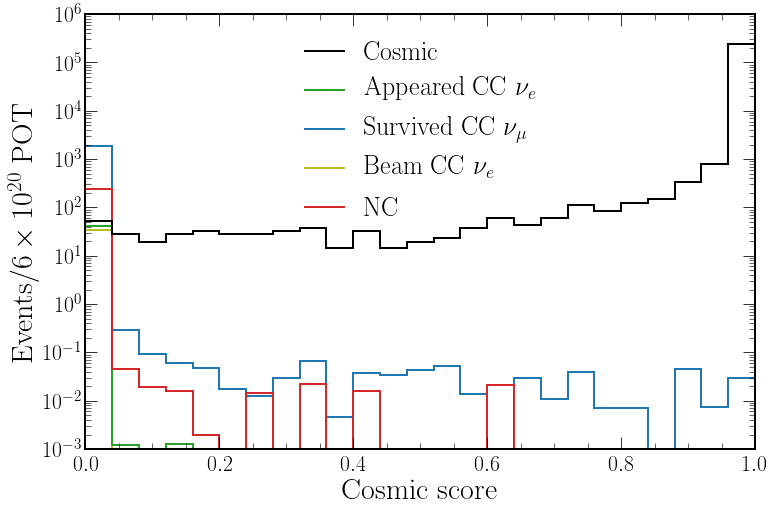

In [18]:
chipsnet.plotting.plot_cosmic_values(events, "final_cosmic", save_path+"final_cosmic_outputs")

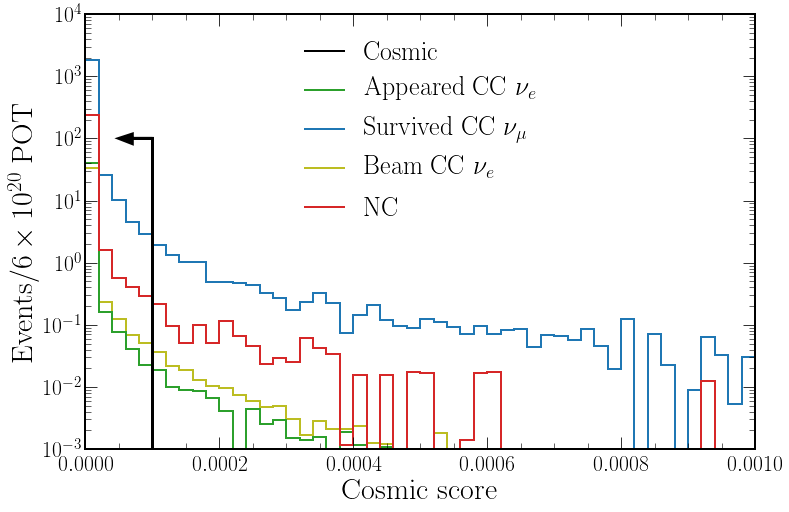

In [7]:
chipsnet.plotting.plot_cosmic_values(events, "final_cosmic", save_path+"final_cosmic_zoomed_outputs", zoom=True)

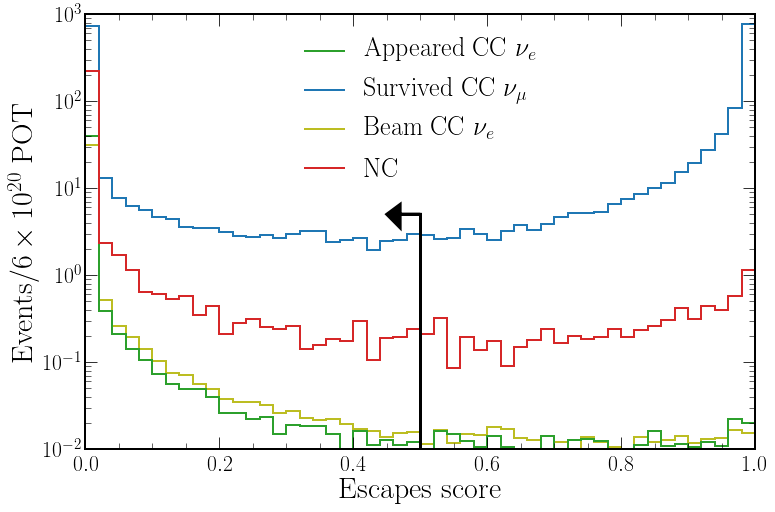

In [20]:
chipsnet.plotting.plot_escapes_values(events, "final_cosmic", save_path+"final_escapes_outputs")

In [35]:
esc_labels = ["Contained", "Escaped"]
nuel_esc_report = classification_report(
    events[events["t_comb_cat"] == 0]["t_escapes"],
    events[events["t_comb_cat"] == 0]["escapes_cut"],
    labels=[x for x in range(2)],
    target_names=esc_labels,
    sample_weight=events[events["t_comb_cat"] == 0]["w"],
    zero_division=0
)
numu_esc_report = classification_report(
    events[events["t_comb_cat"] == 1]["t_escapes"],
    events[events["t_comb_cat"] == 1]["escapes_cut"],
    labels=[x for x in range(2)],
    target_names=esc_labels,
    sample_weight=events[events["t_comb_cat"] == 1]["w"],
    zero_division=0
)
print(nuel_esc_report)
print(numu_esc_report)

              precision    recall  f1-score   support

   Contained       0.99      0.99      0.99 78.60574469903906
     Escaped       0.02      0.08      0.03 0.17935234456193436

   micro avg       0.98      0.99      0.99 78.785097043601
   macro avg       0.51      0.53      0.51 78.785097043601
weighted avg       0.99      0.99      0.99 78.785097043601

              precision    recall  f1-score   support

   Contained       0.95      0.97      0.96 896.9127039992077
     Escaped       0.98      0.96      0.97 1145.7450205386965

   micro avg       0.96      0.97      0.97 2042.6577245379042
   macro avg       0.96      0.97      0.96 2042.6577245379042
weighted avg       0.96      0.97      0.97 2042.6577245379042



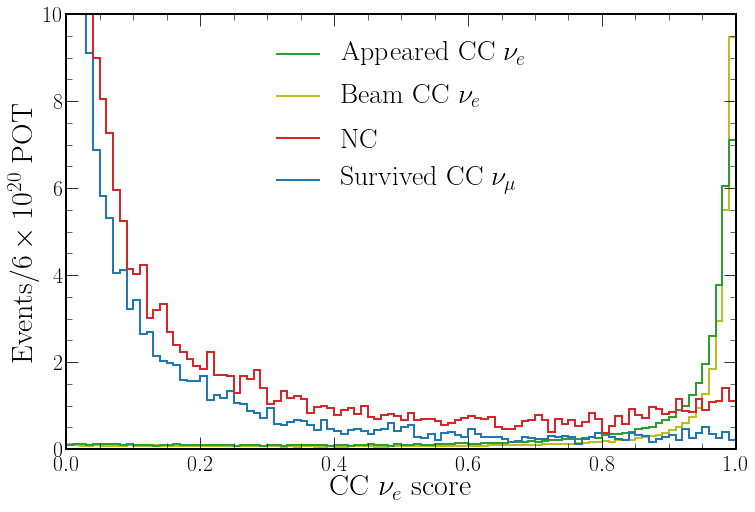

In [17]:
chipsnet.plotting.plot_combined_values(events, 0, "final_beam_", save_path+"final_beam_nuel_outputs")

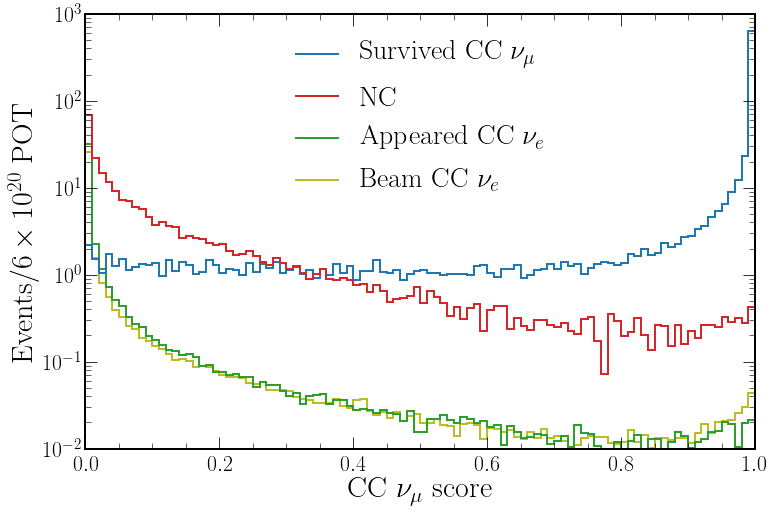

In [16]:
chipsnet.plotting.plot_combined_values(events, 1, "final_beam_", save_path+"final_beam_numu_outputs")

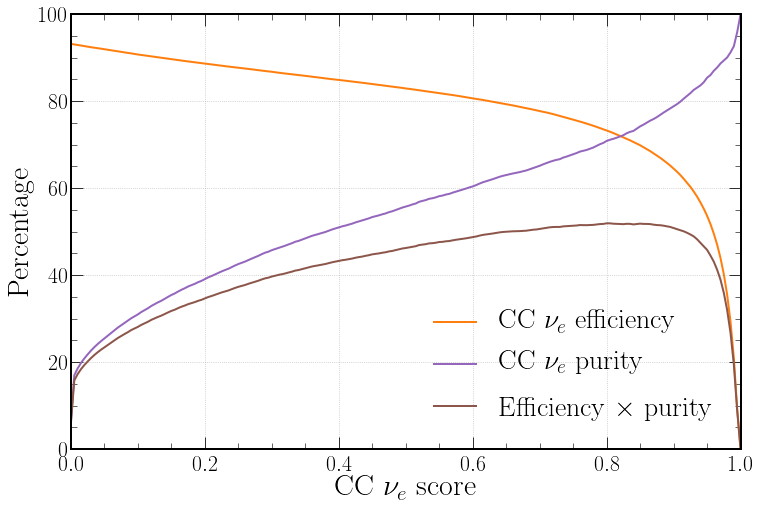

In [73]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 0, save_path+"final_nuel_eff_curves", leg_pos="lower right")

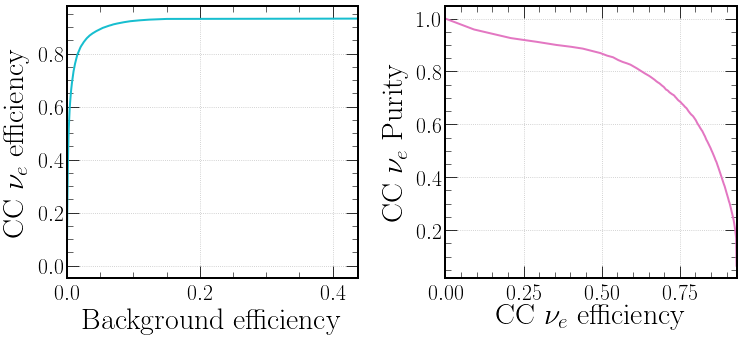

In [74]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 0, save_path+"final_nuel_comp_curves")

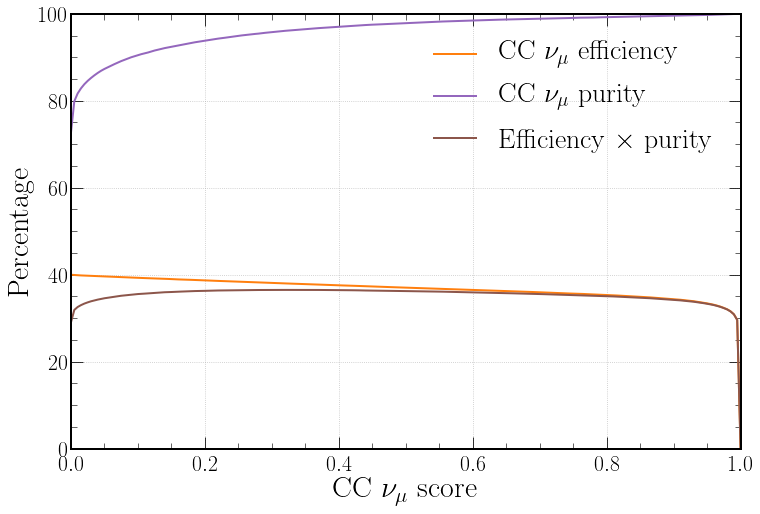

In [75]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 1, save_path+"final_numu_eff_curves", full=True)

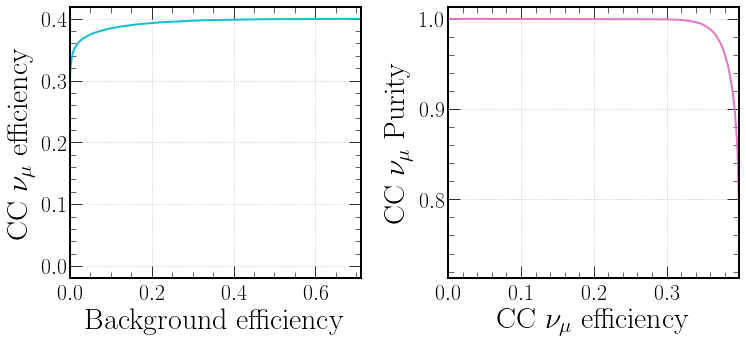

In [76]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 1, save_path+"final_numu_comp_curves")

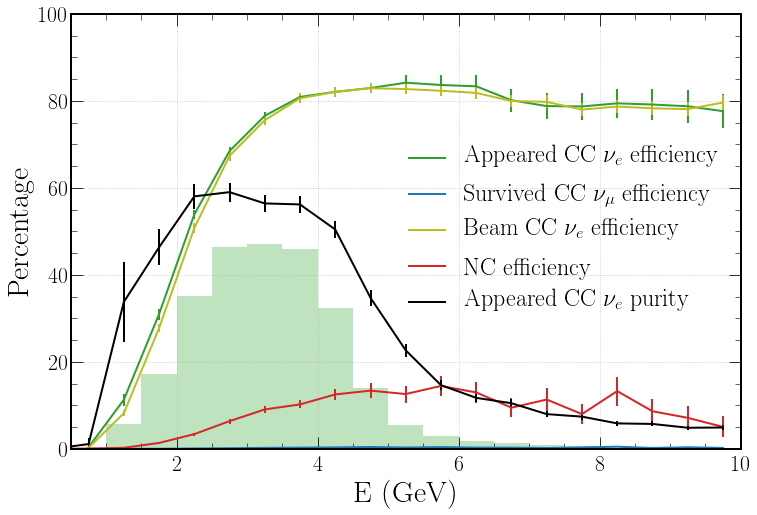

In [48]:
chipsnet.plotting.plot_nuel_hists([outputs[0]], events, save_path+"final_nuel_hists")

In [ ]:
total = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()
passed = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0.25, 10.25, 0.5)
styles = ["solid", "dashed", "dotted", "dashdot"]

axs.errorbar(
    bins,
    events[i]["fom_effs"][0][0][0] * 100,
    yerr=events[i]["fom_effs"][0][0][1] * 100,
    color="tab:green",
    linestyle=styles[i],
    linewidth=2
)
plt.show()

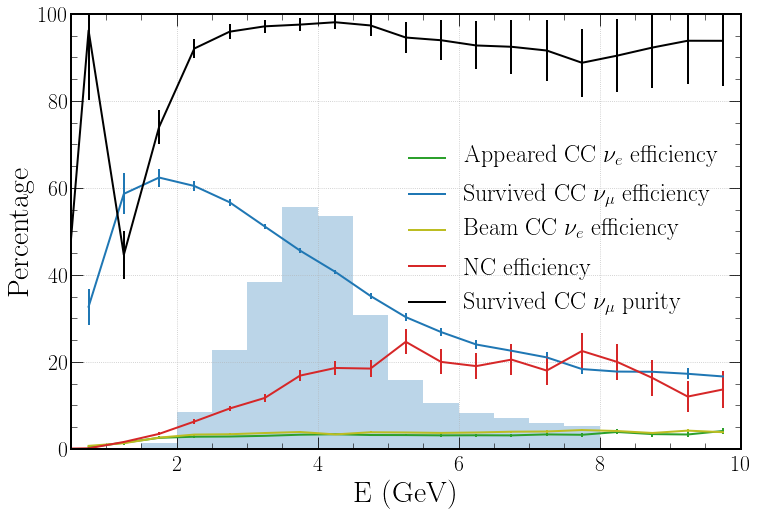

In [49]:
chipsnet.plotting.plot_numu_hists([outputs[0]], events, save_path+"final_numu_hists")

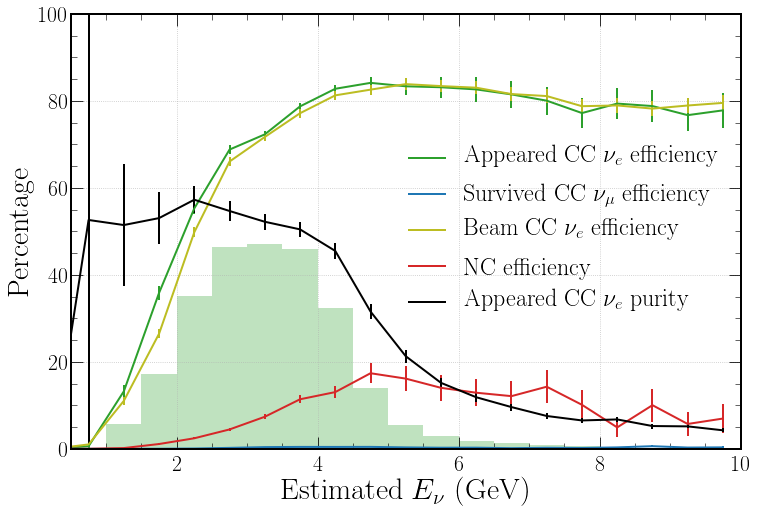

In [50]:
nuel_out = chipsnet.utils.calculate_eff_pur(events, outputs[0]["max_fom_cuts_0"], prefix="final_beam_", energy="pred_nuel_energy")
chipsnet.plotting.plot_nuel_hists([nuel_out], events, save_path+"final_nuel_hists_reco", energy=r"Estimated $E_{\nu}$ (GeV)")

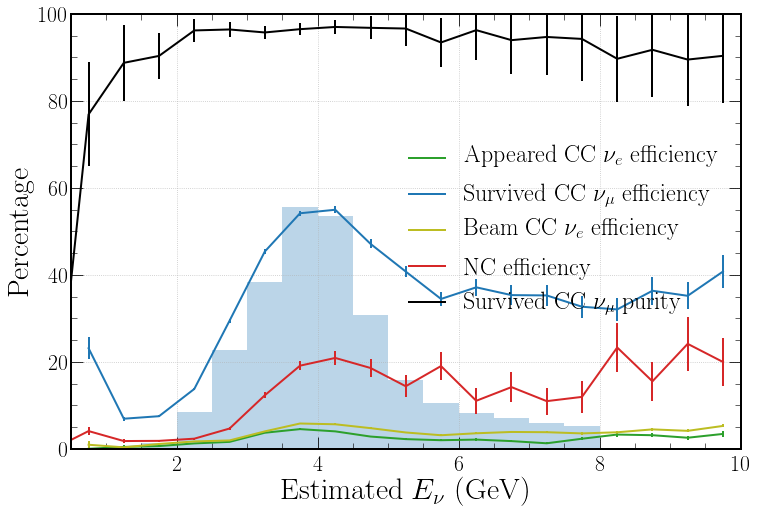

In [51]:
numu_out = chipsnet.utils.calculate_eff_pur(events, outputs[0]["max_fom_cuts_0"], prefix="final_beam_", energy="pred_numu_energy")
chipsnet.plotting.plot_numu_hists([numu_out], events, save_path+"final_numu_hists_reco", energy=r"Estimated $E_{\nu}$ (GeV)")

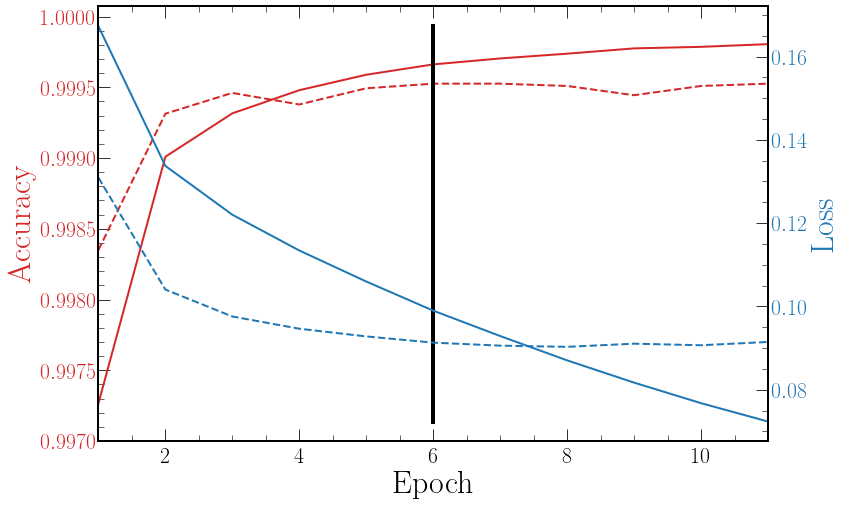

In [19]:
chipsnet.plotting.plot_history(config, "final_cosmic", save_path+"final_cosmic_history", key="t_cosmic_cat_accuracy", label="Accuracy")

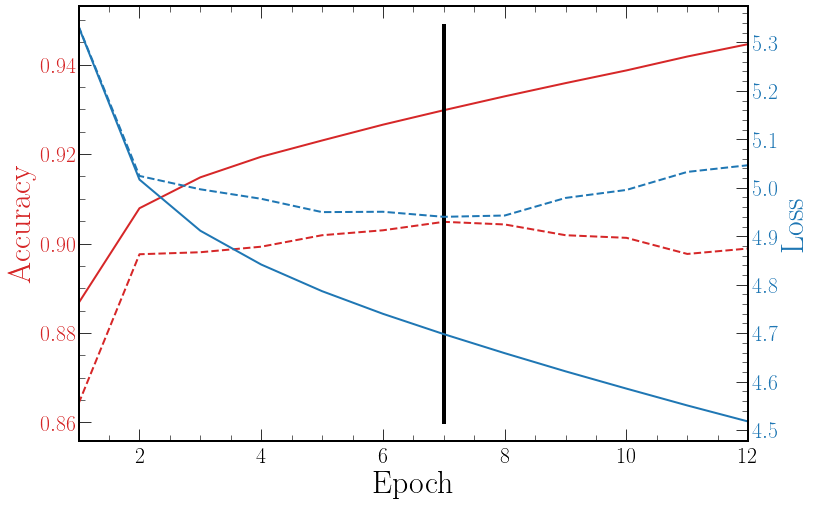

In [20]:
chipsnet.plotting.plot_history(config, "final_beam", save_path+"final_beam_history", key="t_comb_cat_accuracy", label="Accuracy")

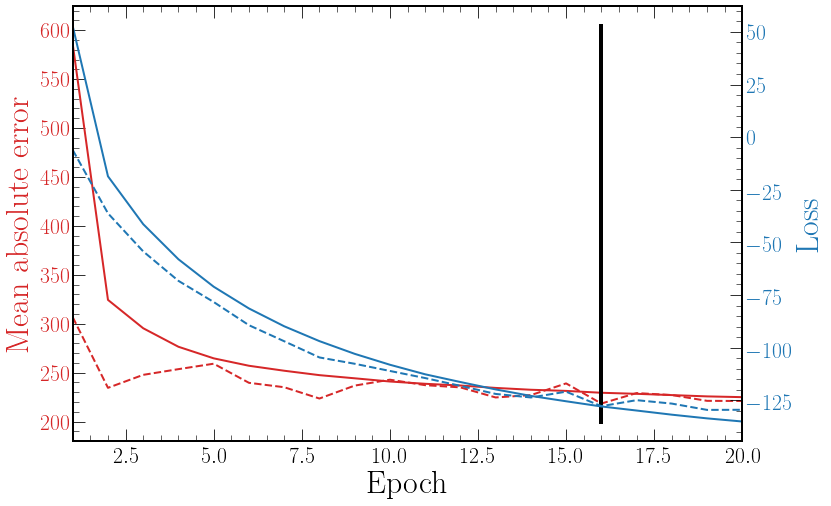

In [14]:
chipsnet.plotting.plot_history(config, "final_nuel_ccqel_e", save_path+"final_energy_history", key="t_nu_energy_mae", type="min", label="Mean absolute error")

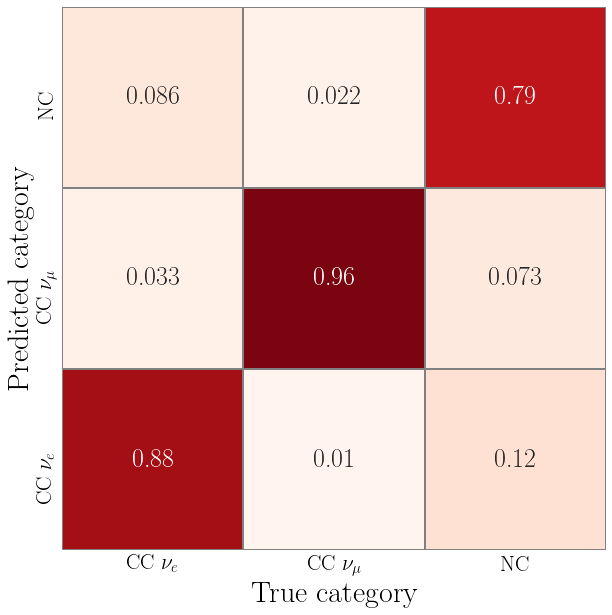

In [63]:
plt.figure(figsize=(10, 10))
labels = [r"CC $\nu_{e}$", r"CC $\nu_{\mu}$", r"NC"]
sns.heatmap(
    outputs[0]["comb_matrix"].drop(0, axis=0).drop(3, axis=1),
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=labels,
    yticklabels=labels[::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

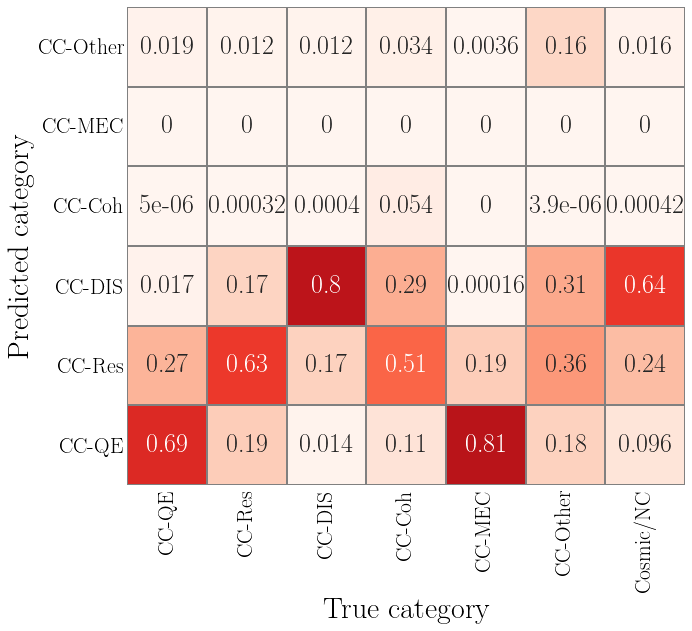

In [7]:
events["final_beam_t_cc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_cat")["categories"], "final_beam_pred_t_cc_cat_"),
)
cc_matrix = confusion_matrix(
    events[events["nuel_selected"] | events["numu_selected"]]["t_cc_cat"],
    events[events["nuel_selected"] | events["numu_selected"]]["final_beam_t_cc_cat_class"],
    labels=[x for x in range(7)],
    sample_weight=events[events["nuel_selected"] | events["numu_selected"]]["w"],
    normalize="true",
)
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_CC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_CC_CAT["labels"][:6][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_cat_confusion")

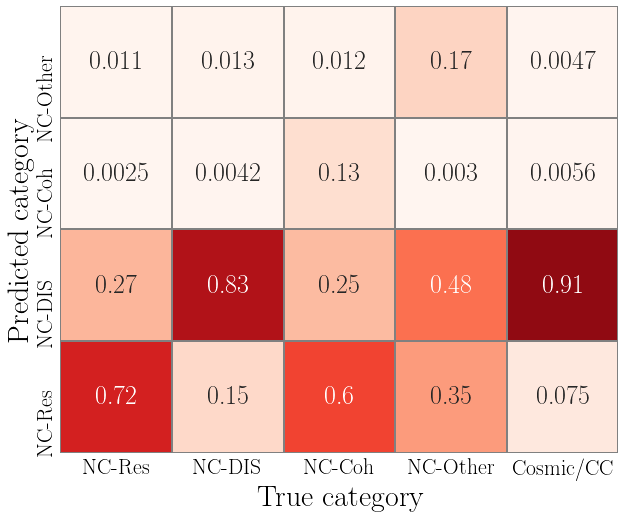

In [8]:
events["final_beam_t_nc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_cat")["categories"], "final_beam_pred_t_nc_cat_"),
)
nc_matrix = confusion_matrix(
    events[events["nc_selected"]]["t_nc_cat"],
    events[events["nc_selected"]]["final_beam_t_nc_cat_class"],
    labels=[x for x in range(5)],
    sample_weight=events[events["nc_selected"]]["w"],
    normalize="true",
)
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_NC_CAT["labels"],
    yticklabels=chipsnet.data.MAP_NC_CAT["labels"][:4][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_cat_confusion")

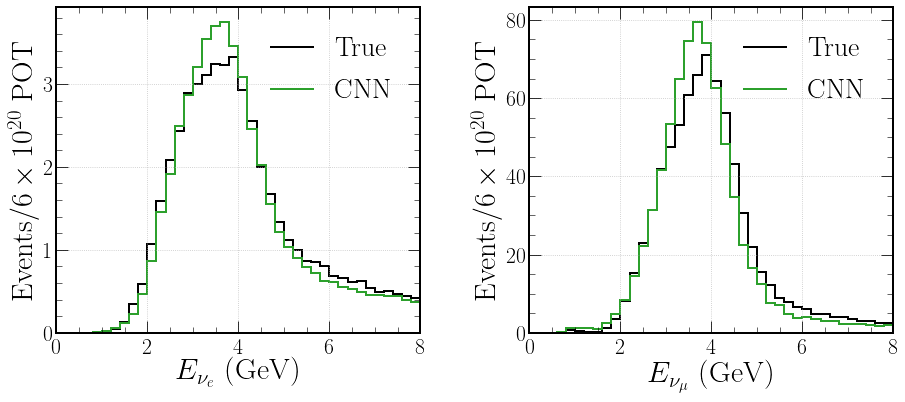

In [19]:
e_range = (0,8)
e_bins = 40

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["t_nu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["pred_nuel_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)

axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["t_nu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)
axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["pred_numu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)

axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
true = Line2D([0], [0], color="black", linewidth=2, label=r"True")
reco = Line2D([0], [0], color="tab:green", linewidth=2, label=r"CNN")
axs[0].legend(handles=[true, reco], loc="upper right", fontsize=28)
axs[1].legend(handles=[true, reco], loc="upper right", fontsize=28)

chipsnet.plotting.save(save_path + "final_energy_dists")

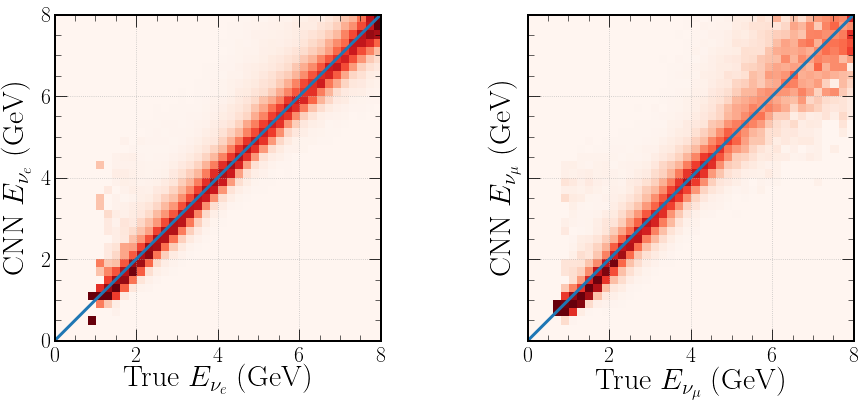

In [22]:
e_range = [[0, 8], [0, 8]]
extent = (0, 8, 0, 8)
e_bins = [40, 40]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
plt.setp(axs, xticks=[0, 2, 4, 6, 8], yticks=[0, 2, 4, 6, 8])

nuel_cc_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["final_nuel_cc_e_pred_t_nu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_cc_h = np.nan_to_num(nuel_cc_h/nuel_cc_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_cc_h, "nuel_cc")

numu_cc_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["final_numu_cc_e_pred_t_nu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_cc_h = np.nan_to_num(numu_cc_h/numu_cc_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_cc_h, "numu_cc")

axs[0].imshow(nuel_cc_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0].grid()
axs[0].label_outer()
axs[0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[0].set_xlabel(r"True $E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"CNN $E_{\nu_{e}}$ (GeV)", fontsize=30)

axs[1].imshow(numu_cc_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1].grid()
axs[1].label_outer()
axs[1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[1].set_xlabel(r"True $E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"CNN $E_{\nu_{\mu}}$ (GeV)", fontsize=30)

chipsnet.plotting.save(save_path + "final_energy_2d")

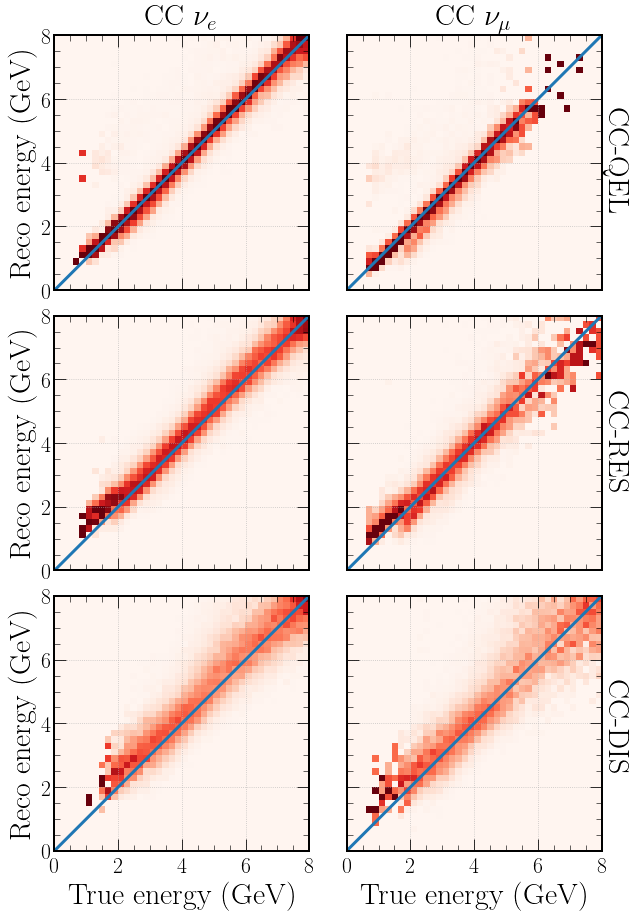

In [17]:
e_range = [[0, 8], [0, 8]]
extent = (0, 8, 0, 8)
e_bins = [40, 40]
fig, axs = plt.subplots(3, 2, figsize=(10, 15), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2, 4, 6, 8], yticks=[0, 2, 4, 6, 8])

nuel_ccqel_h = np.histogram2d(events[(events["nuel_selected"] == 1) & ((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4))]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & ((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4))]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccqel_h = np.nan_to_num(nuel_ccqel_h/nuel_ccqel_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccqel_h, "nuel_ccqel")
axs[0, 0].imshow(nuel_ccqel_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[0, 0].set_title(r"CC $\nu_{e}$", fontsize=30)
axs[0, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
nuel_ccres_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccres_h = np.nan_to_num(nuel_ccres_h/nuel_ccres_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccres_h, "nuel_ccres")
axs[1, 0].imshow(nuel_ccres_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[1, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
nuel_ccdis_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccdis_h = np.nan_to_num(nuel_ccdis_h/nuel_ccdis_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccdis_h, "nuel_ccdis")
axs[2, 0].imshow(nuel_ccdis_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[2, 0].set_xlabel(r"True energy (GeV)", fontsize=30)
axs[2, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccqel_h = np.histogram2d(events[(events["numu_selected"] == 1) & ((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10))]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & ((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10))]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccqel_h = np.nan_to_num(numu_ccqel_h/numu_ccqel_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccqel_h, "numu_ccqel")
axs[0, 1].imshow(numu_ccqel_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"CC $\nu_{\mu}$", fontsize=30)
axs[0, 1].text(8.050, 2.600, "CC-QEL", rotation=-90, fontsize=30)
axs[0, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccres_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccres_h = np.nan_to_num(numu_ccres_h/numu_ccres_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccres_h, "numu_ccres")
axs[1, 1].imshow(numu_ccres_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8.050, 2.600, "CC-RES", rotation=-90, fontsize=30)
axs[1, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccdis_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccdis_h = np.nan_to_num(numu_ccdis_h/numu_ccdis_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccdis_h, "numu_ccdis")
axs[2, 1].imshow(numu_ccdis_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8.050, 2.600, "CC-DIS", rotation=-90, fontsize=30)
axs[2, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[2, 1].set_xlabel(r"True energy (GeV)", fontsize=30)
chipsnet.plotting.save(save_path + "final_energy_2d_cats")

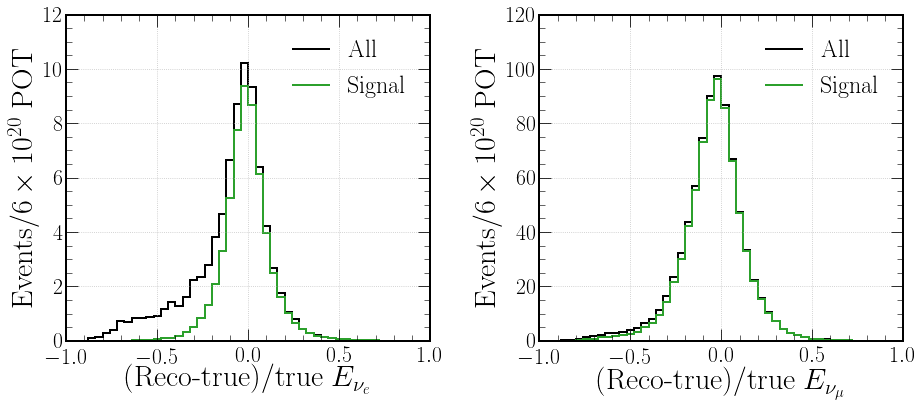

In [23]:
e_range = (-1,1)
e_bins = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs[0].hist(
    events[(events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["nuel_selected"] == 1)]["w"],
    histtype="step"
)
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)

axs[1].hist(
    events[(events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["numu_selected"] == 1)]["w"],
    histtype="step"
)
axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)

axs[0].set_ylim(0, 12)
axs[1].set_ylim(0, 120)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_xlabel(r"(Reco-true)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
sel = Line2D([0], [0], color="black", linewidth=2, label=r"All")
cat = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Signal")
axs[0].legend(handles=[sel, cat], loc="upper right", fontsize=24)
axs[1].legend(handles=[sel, cat], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_frac")

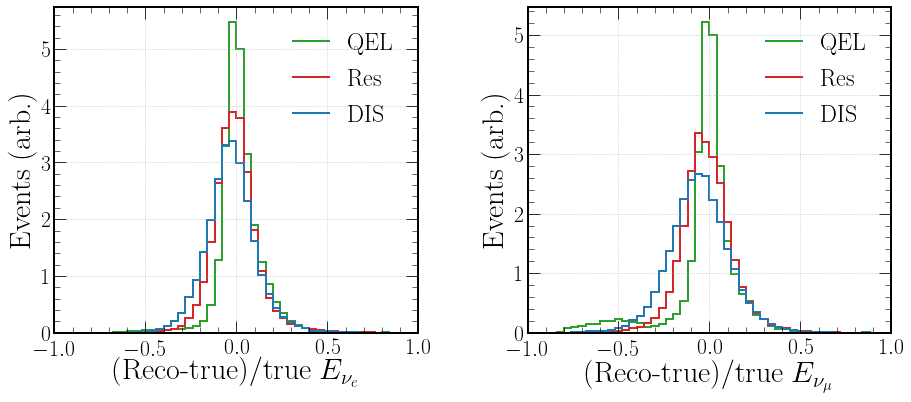

In [24]:
e_range = (-1,1)
e_bins = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs[0].hist(
    events[((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4)) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4)) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    events[(events["t_all_cat"] == 1) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 1) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    events[(events["t_all_cat"] == 2) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 2) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10)) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10)) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[(events["t_all_cat"] == 7) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 7) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[(events["t_all_cat"] == 8) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 8) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)

axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylabel(r"Events (arb.)", fontsize=30)
axs[1].set_xlabel(r"(Reco-true)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[1].set_ylabel(r"Events (arb.)", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)
axs[1].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_frac_split")

In [25]:
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel: {}".format(stds[0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu: {}".format(stds[0]))

Nuel: [0.10256737242240417]
Numu: [0.126333459493101]


In [26]:
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel: {}".format(stds[0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu: {}".format(stds[0]))

Nuel: [0.1290346299921029]
Numu: [0.12876040547326284]


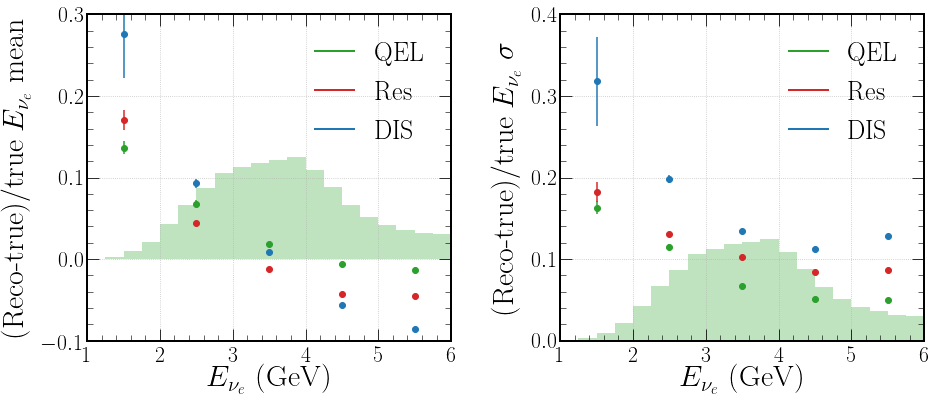

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 0)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")

axs[0].hist(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 0.03,
)
axs[1].hist(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 0.03,
)

axs[0].set_ylim(-0.1, 0.3)
axs[0].set_xlim(1, 6)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 6)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"(Reco-true)/true $E_{\nu_{e}}$ mean", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"(Reco-true)/true $E_{\nu_{e}}$ $\sigma$", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=26)
axs[1].legend(handles=[qel, res, dis], loc="upper right", fontsize=26)

chipsnet.plotting.save(save_path + "final_energy_nuel")

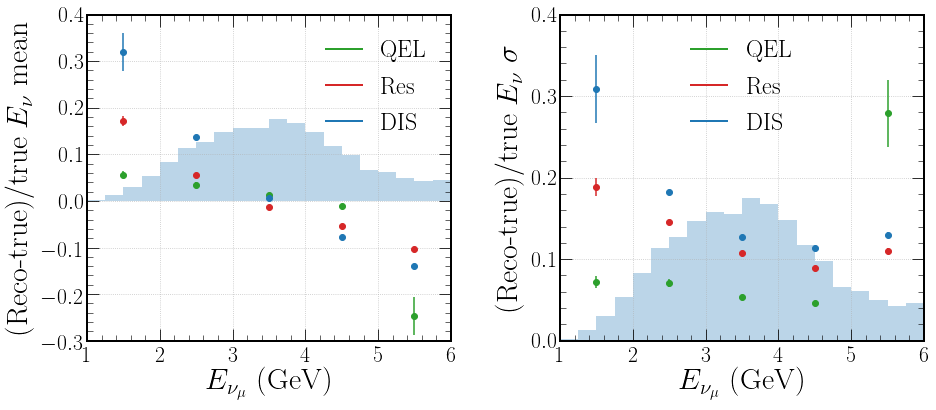

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 6)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")

axs[0].hist(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 1.0,
)
axs[1].hist(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 1.0,
)

axs[0].set_ylim(-0.3, 0.4)
axs[0].set_xlim(1, 6)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 6)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"(Reco-true)/true $E_{\nu}$ mean", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"(Reco-true)/true $E_{\nu}$ $\sigma$", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)
axs[1].legend(handles=[qel, res, dis], loc="upper center", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_numu")

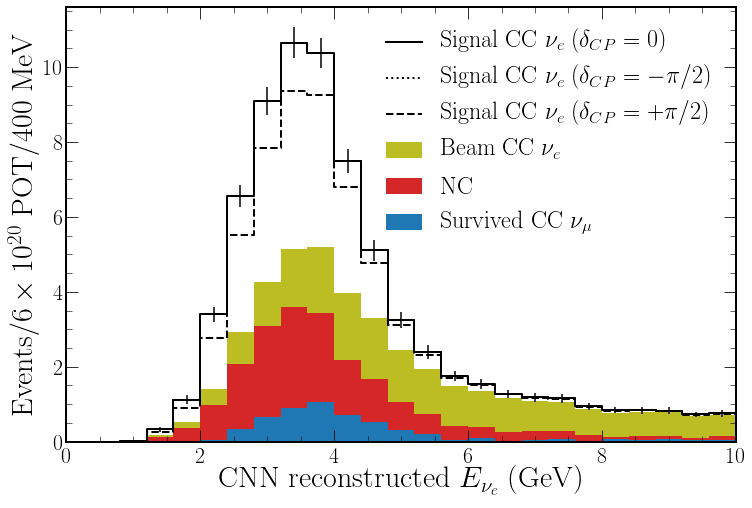

In [33]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins

# Zero cp
numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, numu_h, bin_range, color="tab:blue")
axs.bar(bins, nc_h, bin_range, bottom=numu_h, color="tab:red")
axs.bar(bins, nuel_b_h, bin_range, bottom=nc_h+numu_h, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, yerr=err, bottom=nuel_b_h+nc_h+numu_h, color="tab:green", alpha=0)

left,right = e[:-1],e[1:]
x = np.array([left,right]).T.flatten()
y = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
y_minus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2,(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2]).T.flatten()
plt.plot(x,y, color="black", linewidth=2, linestyle="solid")

# Plus cp
plus_events = chipsnet.utils.apply_weights(events, osc_file_name=matter_osc_file_plus_f)
numu_ev = plus_events[(plus_events["t_comb_cat"]==1) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = plus_events[(plus_events["t_comb_cat"]==0) & (plus_events["t_sample_type"]==1) & (plus_events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = plus_events[(plus_events["t_comb_cat"]==0) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)
nc_ev = plus_events[(plus_events["t_comb_cat"]==2) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
y_plus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
plt.plot(x,y_plus, color="black", linewidth=2, linestyle="dashed")

# Minus cp
minus_events = chipsnet.utils.apply_weights(events, osc_file_name=matter_osc_file_minus_f)
numu_ev = minus_events[(minus_events["t_comb_cat"]==1) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = minus_events[(minus_events["t_comb_cat"]==0) & (minus_events["t_sample_type"]==1) & (minus_events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = minus_events[(minus_events["t_comb_cat"]==0) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)
nc_ev = minus_events[(minus_events["t_comb_cat"]==2) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
y_minus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
plt.plot(x,y_minus, color="black", linewidth=2, linestyle="dotted")

nuel = Patch(facecolor="tab:olive", label=r"Beam CC $\nu_{e}$")
osc_nuel = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=0$)")
numu = Patch(facecolor="tab:blue", label=r"Survived CC $\nu_{\mu}$")
nc = Patch(facecolor="tab:red", label=r"NC")
minus = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=-\pi/2$)")
plus = Line2D([0], [0], color="black", linewidth=2, linestyle="dashed", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=+\pi/2$)")
axs.legend(handles=[osc_nuel, minus, plus, nuel, nc, numu], loc="upper right", fontsize=24)
axs.set_xlabel(r"CNN reconstructed $E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/400 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "final_nuel_passed_energy_dist")

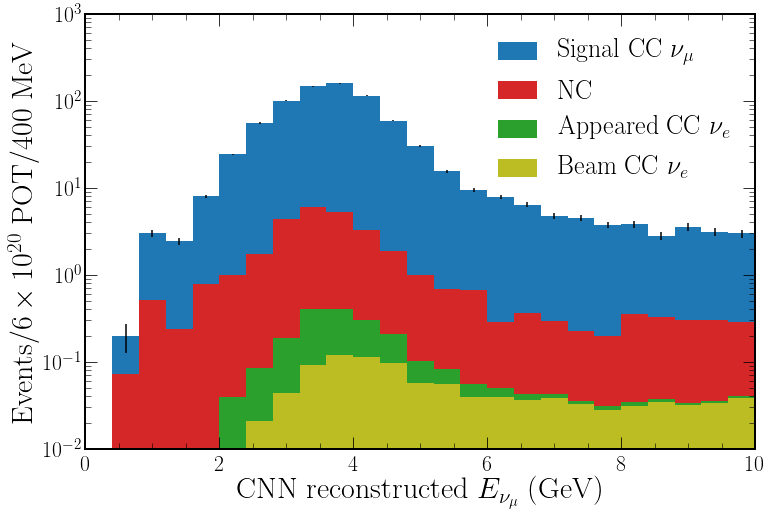

In [32]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins
escapes_cut=0.5

numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["numu_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, nuel_b_h, bin_range, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, bottom=nuel_b_h, color="tab:green")
axs.bar(bins, nc_h, bin_range, bottom=nuel_o_h+nuel_b_h, color="tab:red")
axs.bar(bins, numu_h, bin_range, yerr=err, bottom=nc_h+nuel_o_h+nuel_b_h, color="tab:blue")
axs.set_yscale("log")
axs.set_ylim(10e-3, 10e2)

nuel = Patch(facecolor="tab:olive", label=r"Beam CC $\nu_{e}$")
osc_nuel = Patch(facecolor="tab:green", label=r"Appeared CC $\nu_{e}$")
numu = Patch(facecolor="tab:blue", label=r"Signal CC $\nu_{\mu}$")
nc = Patch(facecolor="tab:red", label=r"NC")
axs.legend(handles=[numu, nc, osc_nuel, nuel], loc="upper right", fontsize=26)
axs.set_xlabel(r"CNN reconstructed $E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/400 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "final_numu_passed_energy_dist")

In [31]:
out_80 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.8) & (events["frac_energy"] < 1.0)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_60 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.6) & (events["frac_energy"] < 0.8)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_40 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.4) & (events["frac_energy"] < 0.6)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_20 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.2) & (events["frac_energy"] < 0.4)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")

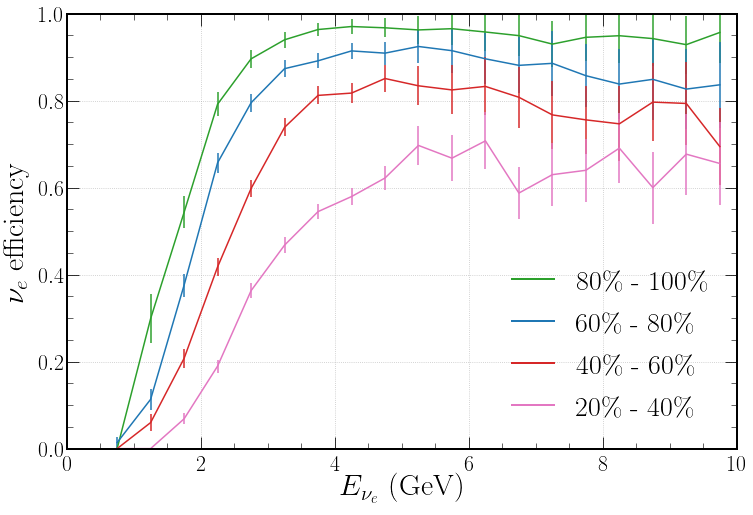

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0.25, 10.25, 0.5)
axs.errorbar(
    bins,
    out_80["fom_effs"][0][0][0],
    yerr=out_80["fom_effs"][0][0][1],
    color="tab:green"
)
axs.errorbar(
    bins,
    out_60["fom_effs"][0][0][0],
    yerr=out_60["fom_effs"][0][0][1],
    color="tab:blue"
)
axs.errorbar(
    bins,
    out_40["fom_effs"][0][0][0],
    yerr=out_40["fom_effs"][0][0][1],
    color="tab:red"
)
axs.errorbar(
    bins,
    out_20["fom_effs"][0][0][0],
    yerr=out_20["fom_effs"][0][0][1],
    color="tab:pink"
)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"$\nu_{e}$ efficiency", fontsize=30)
axs.set_ylim([0, 1])
leg_80 = Line2D([0], [0], color="tab:green", linewidth=2, label=r"80\% - 100\%")
leg_60 = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"60\% - 80\%")
leg_40 = Line2D([0], [0], color="tab:red", linewidth=2, label=r"40\% - 60\%")
leg_20 = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"20\% - 40\%")
axs.legend(handles=[leg_80, leg_60, leg_40, leg_20], loc="lower right", fontsize=28)
axs.set_xlim(0, 10)
axs.grid()
chipsnet.plotting.save(save_path + "final_frac_energy_eff")

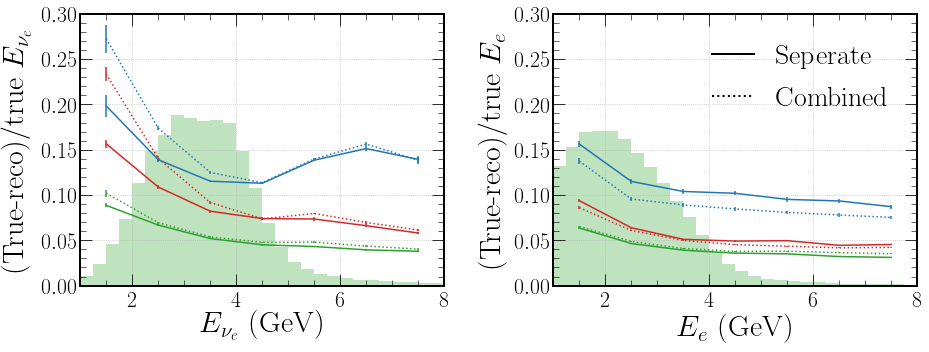

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[0].set_ylabel(r"(True-reco)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylim(0.0, 0.3)
axs[0].grid()
axs[0].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"] * 0.05,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[1].set_ylabel(r"(True-reco)/true $E_{e}$", fontsize=30)
axs[1].set_xlabel(r"$E_{e}$ (GeV)", fontsize=30)
axs[1].set_ylim(0.0, 0.3)
axs[1].grid()
axs[1].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["t_lep_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"] * 0.05,
)

seperate = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper right", fontsize=28)

chipsnet.plotting.save(save_path + "final_energy_split_nuel_frac_vs_e")

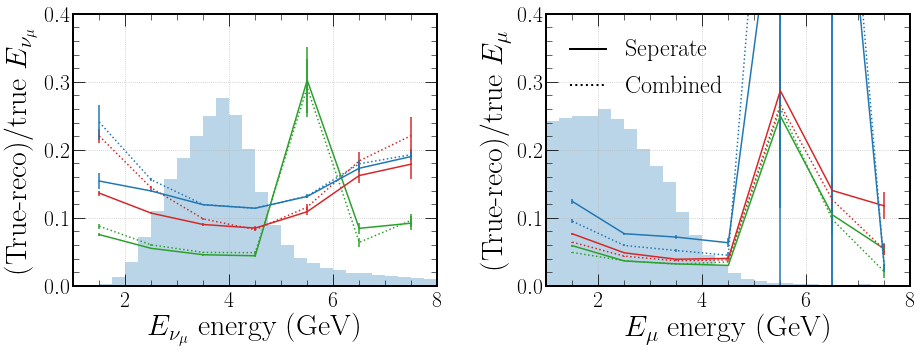

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_ccres_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_ccdis_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[0].set_ylabel(r"(True-reco)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ energy (GeV)", fontsize=30)
axs[0].set_ylim(0.0, 0.4)
axs[0].grid()
axs[0].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["w"] * 0.003,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_ccres_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_ccdis_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[1].set_ylabel(r"(True-reco)/true $E_{\mu}$", fontsize=30)
axs[1].set_xlabel(r"$E_{\mu}$ energy (GeV)", fontsize=30)
axs[1].set_ylim(0.0, 0.4)
axs[1].grid()
axs[1].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["t_lep_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["w"] * 0.004,
)

seperate = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper left", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_split_numu_frac_vs_e")

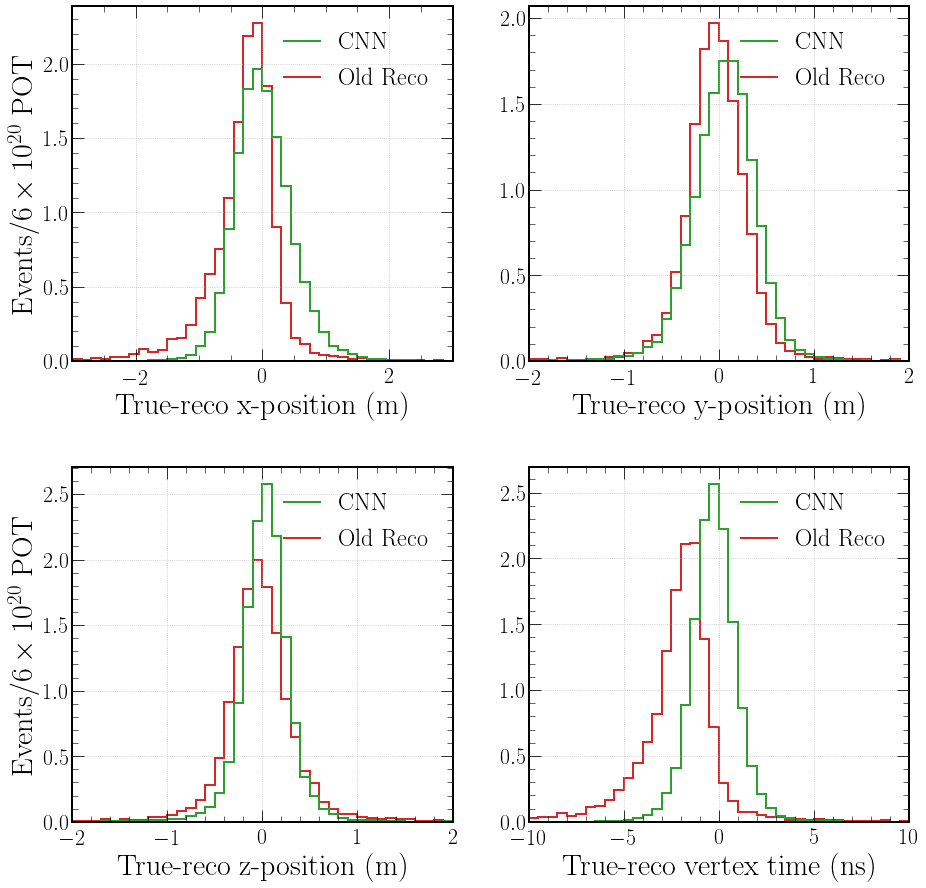

In [182]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'hspace': 0.3})

cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco")

scale = old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()
axs[0, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_x"] - old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_x"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-3, 3), bins=40, color='tab:red', histtype='step', linewidth=2
)
axs[0, 0].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_x"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_x"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-3, 3), bins=40, color='tab:green', histtype='step', linewidth=2
)
axs[0, 0].set_xlabel('True-reco x-position (m)', fontsize=30)
axs[0, 0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0, 0].grid()
axs[0, 0].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

axs[0, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_y"] - old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_y"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
axs[0, 1].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_y"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_y"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
axs[0, 1].set_xlabel('True-reco y-position (m)', fontsize=30)
axs[0, 1].grid()
axs[0, 1].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

axs[1, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_z"] - old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_z"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
axs[1, 0].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_z"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_z"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
axs[1, 0].set_xlabel('True-reco z-position (m)', fontsize=30)
axs[1, 0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1, 0].grid()
axs[1, 0].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

axs[1, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_t"] - old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_t"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-10, 10), bins=40, color='tab:red', histtype='step', linewidth=2
)
axs[1, 1].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_t"]-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_t"],
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-10, 10), bins=40, color='tab:green', histtype='step', linewidth=2
)
axs[1, 1].set_xlabel('True-reco vertex time (ns)', fontsize=30)
axs[1, 1].grid()
axs[1, 1].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "final_vertex_res_comparison")

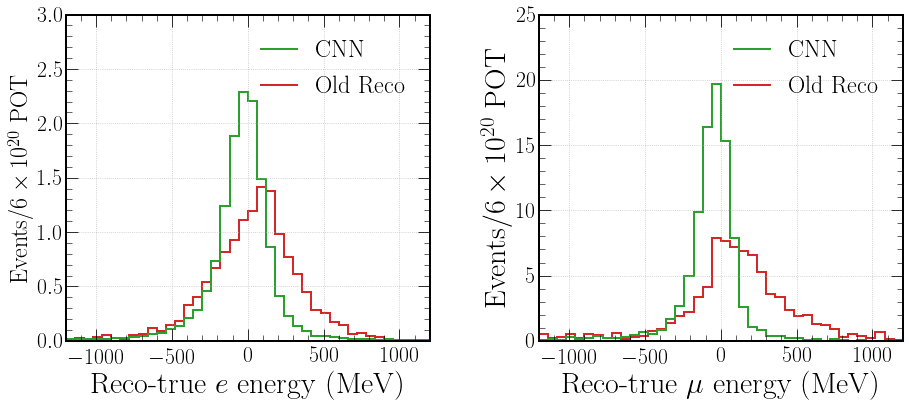

In [186]:
scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 11) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_el"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["r_lep_energy"]-
            old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["t_lep_energy"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-1200, 1200), bins=40, color='tab:red', histtype='step', linewidth=2)
axs[0].hist(events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_lep_energy"]-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_lep_energy"], 
            weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
            range=(-1200, 1200), bins=40, color='tab:green', histtype='step', linewidth=2)
axs[0].set_xlabel('Reco-true $e$ energy (MeV)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=24)
axs[0].grid()
axs[0].set_ylim(0, 3)

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 13) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_mu"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"].sum()

cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco")
axs[0].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["r_lep_energy"]-
            old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["t_lep_energy"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-1200, 1200), bins=40, color='tab:red', histtype='step', linewidth=2)
axs[1].hist(events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_lep_energy"]-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_lep_energy"], 
            weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
            range=(-1200, 1200), bins=40, color='tab:green', histtype='step', linewidth=2)
axs[1].set_xlabel('Reco-true $\mu$ energy (MeV)', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].grid()
axs[1].set_ylim(0, 25)
axs[1].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)
chipsnet.plotting.save(save_path + "final_abs_e_comparison")

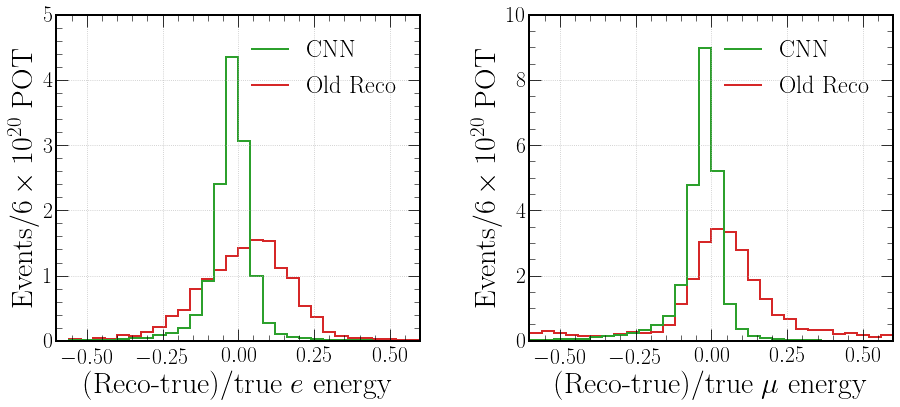

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 11) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_el"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-0.6, 0.6), bins=30, color='tab:red', histtype='step', linewidth=2)
axs[0].hist(events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["frac_el_energy"], 
            weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
            range=(-0.6, 0.6), bins=30, color='tab:green', histtype='step', linewidth=2)
axs[0].set_xlabel('(Reco-true)/true $e$ energy', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].grid()
axs[0].set_ylim(0, 5)

cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN")
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco")
axs[0].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 13) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_mu"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"].sum()

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-0.6, 0.6), bins=30, color='tab:red', histtype='step', density=True, linewidth=2)
axs[1].hist(events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["frac_mu_energy"], 
            weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
            range=(-0.6, 0.6), bins=30, color='tab:green', histtype='step', density=True, linewidth=2)
axs[1].set_xlabel('(Reco-true)/true $\mu$ energy', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].legend(handles=[cvn, old_reco], loc="upper right", fontsize=24)
axs[1].grid()
axs[1].set_ylim(0, 10)
chipsnet.plotting.save(save_path + "final_frac_e_comparison")

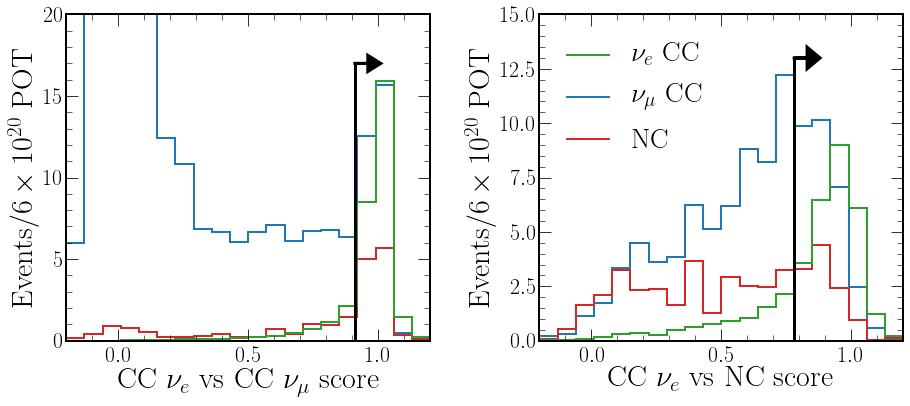

In [235]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

nuel_scale = events[(events["t_comb_cat"] == 0)]["w"].sum()/old_events[(old_events["is_cc"] == True) & (old_events["l_type"]==11)]["w"].sum()
numu_scale = events[(events["t_comb_cat"] == 1)]["w"].sum()/old_events[(old_events["is_cc"] == True) & (old_events["l_type"]==13)]["w"].sum()
nc_scale = events[(events["t_comb_cat"] == 2)]["w"].sum()/old_events[(old_events["is_cc"] == False)]["w"].sum()

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) &  (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*numu_scale,
            range=(-0.2, 1.2), bins=20, color='tab:blue', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*nc_scale,
            range=(-0.2, 1.2), bins=20, color='tab:red', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*nuel_scale,
            range=(-0.2, 1.2), bins=20, color='tab:green', histtype='step', linewidth=2)
axs[0].set_xlabel(r'CC $\nu_{e}$ vs CC $\nu_{\mu}$ score', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].set_ylim(0, 20)
axs[0].plot([0.91, 0.91], [0, 17], "k-", lw=3, color="black")
axs[0].arrow(
    0.91,
    17,
    0.1,
    0,
    color="black",
    lw=3,
    length_includes_head=True,
    head_width=1,
    head_length=0.05,
)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*numu_scale,
            range=(-0.2, 1.2), bins=20, color='tab:blue', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*nc_scale,
            range=(-0.2, 1.2), bins=20, color='tab:red', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*nuel_scale,
            range=(-0.2, 1.2), bins=20, color='tab:green', histtype='step', linewidth=2)
axs[1].set_xlabel(r'CC $\nu_{e}$ vs NC score', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_ylim(0, 15)
axs[1].plot([0.78, 0.78], [0, 13], "k-", lw=3, color="black")
axs[1].arrow(
    0.78,
    13,
    0.1,
    0,
    color="black",
    lw=3,
    length_includes_head=True,
    head_width=1,
    head_length=0.05,
)

nuel = Line2D(
    [0],
    [0],
    color="tab:green",
    linewidth=2,
    linestyle="solid",
    label=r"$\nu_{e}$ CC",
)
numu = Line2D(
    [0],
    [0],
    color="tab:blue",
    linewidth=2,
    linestyle="solid",
    label=r"$\nu_{\mu}$ CC",
)
nc = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"NC")
axs[1].legend(handles=[nuel, numu, nc], loc="upper left", fontsize=28)

chipsnet.plotting.save(save_path + "final_old_pid_outputs")

In [223]:
total_nuel = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()*nuel_scale
pass_nuel = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()*nuel_scale
pass_numu = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["is_cc"]) & (old_events["l_type"]==13)]["w"].sum()*numu_scale
pass_nc = old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"].sum()*nc_scale
print("Passed events-> Nuel: {:.5f}, Numu: {:.5f}, NC: {:.5f}".format(pass_nuel, pass_numu, pass_nc))
print("Nuel-> Eff: {:.5f}, Pur: {:.5f}".format(pass_nuel/total_nuel, pass_nuel/(pass_nuel+pass_numu+pass_nc)))
print("FOM-> {:.5f}".format((pass_nuel/total_nuel)*(pass_nuel/(pass_nuel+pass_numu+pass_nc))))

Passed events-> Nuel: 26.60281, Numu: 30.18774, NC: 11.25762
Nuel-> Eff: 0.33776, Pur: 0.39094
FOM-> 0.13205


In [34]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='calib_time'></a>

## Model calibration sensitivity: time (calib_time)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_2, out_2 = chipsnet.utils.evaluate(config, "calib_time_2", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_5, out_5 = chipsnet.utils.evaluate(config, "calib_time_5", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "calib_time_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "calib_time_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_time_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_time_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_time_numu_eff_curves", full=True)

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_time_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_2, out_2
del ev_5, out_5
del ev_10, out_10
del ev_20, out_20

<a id='calib_charge_rand'></a>

## Model calibration sensitivity: charge random (calib_charge_rand)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "calib_charge_rand_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "calib_charge_rand_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0]], 0, save_path+"calib_charge_rand_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0]], 0, save_path+"calib_charge_rand_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_10[0], out_20[0]], 1, save_path+"calib_charge_rand_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_10[0], out_20[0]], 1, save_path+"calib_charge_rand_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_10, out_10
del ev_20, out_20

<a id='calib_charge_shift'></a>

## Model calibration sensitivity: charge shift (calib_charge_shift)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_5, out_5 = chipsnet.utils.evaluate(config, "calib_charge_shift_5", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "calib_charge_shift_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "calib_charge_shift_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_charge_shift_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_charge_shift_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_charge_shift_numu_eff_curves", full=True)

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_charge_shift_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_5, out_5
del ev_10, out_10
del ev_20, out_20

<a id='calib_noise'></a>

## Model calibration sensitivity: noise (calib_noise)
* 1
* 2
* 3

In [ ]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_2, out_2 = chipsnet.utils.evaluate(config, "calib_noise_2", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_5, out_5 = chipsnet.utils.evaluate(config, "calib_noise_5", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_10, out_10 = chipsnet.utils.evaluate(config, "calib_noise_10", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])
ev_20, out_20 = chipsnet.utils.evaluate(config, "calib_noise_20", ["final_cosmic", "final_beam"], ["t_cosmic_cat", "t_comb_cat"])

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_noise_nuel_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 0, save_path+"calib_noise_nuel_comp_curves")

In [ ]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_noise_numu_eff_curves")

In [ ]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_5[0], out_10[0], out_20[0]], 1, save_path+"calib_noise_numu_comp_curves")

In [ ]:
# Tidy up
del ev_0, out_0
del ev_2, out_2
del ev_5, out_5
del ev_10, out_10
del ev_20, out_20

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification

In [4]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic", ["final_cosmic"], ["t_cosmic_cat"], exclude_images=False)
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform_cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (28919,0.11595), (0,0.00000), (16821,71.97538)
count    16821.000000
mean         0.999264
std          0.015626
min          0.060418
25%          0.999993
50%          1.000000
75%          1.000000
max          1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
count    24067.000000
mean         0.943565
std          0.131641
min          0.000060
25%          0.955152
50%          0.993436
75%          0.999296
max          1.000000
Name: final_cosmic_pred_t_escapes, dtype: float64
Cuts:    (13847,0.94849), (8817,0.41328), (8651,0.76925), (0,0.00000)
took 42.18 seconds


In [5]:
pca_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (6)
Explained variation per principal component: [0.40846742 0.2287146 ]


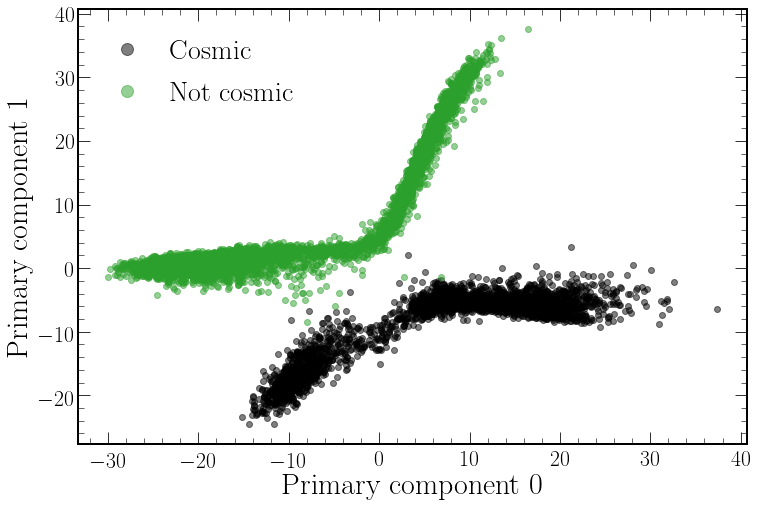

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="Cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="Not cosmic", alpha=0.5, color="tab:green")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('Primary component 0', fontsize=30)
axs.set_ylabel('Primary component 1', fontsize=30)
chipsnet.plotting.save(save_path + "final_cosmic_pca")

In [7]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (6)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.075s...
[t-SNE] Computed neighbors for 10000 samples in 131.304s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.267783
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.093956
[t-SNE] KL divergence after 300 iterations: 2.47

In [11]:
cosmic_index = events[events["t_cosmic_cat"] == 1]["final_cosmic_pred_t_cosmic_cat"].idxmin()
print("Cosmic: ({:.3f},{:.3f})".format(
    events[events["t_cosmic_cat"] == 1]["tsne0"][cosmic_index],
    events[events["t_cosmic_cat"] == 1]["tsne1"][cosmic_index],
))

Cosmic: (1.505,-5.157)


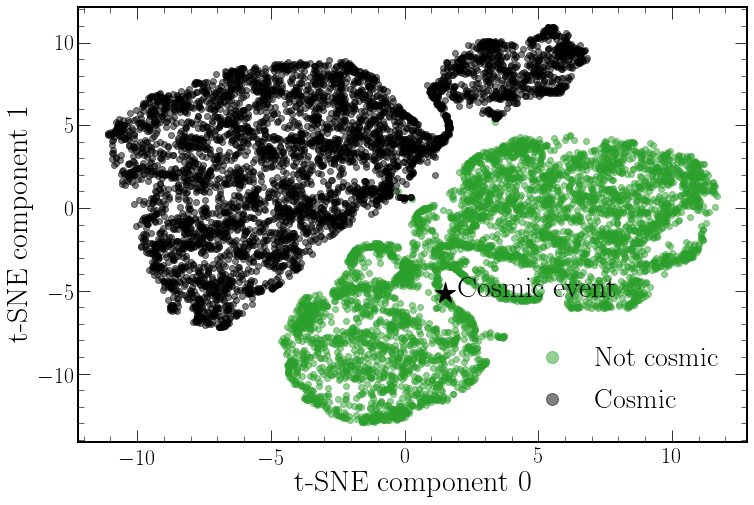

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="Not cosmic", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="Cosmic", alpha=0.5, color="black")
axs.plot(events[events["t_cosmic_cat"] == 1]["tsne0"][cosmic_index], events[events["t_cosmic_cat"] == 1]["tsne1"][cosmic_index], marker='*', linestyle='', ms=22, color="black")
axs.text(events[events["t_cosmic_cat"] == 1]["tsne0"][cosmic_index]+0.5, events[events["t_cosmic_cat"] == 1]["tsne1"][cosmic_index]-0.25, r"Cosmic event", fontsize=30, weight="bold")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('t-SNE component 0', fontsize=30)
axs.set_ylabel('t-SNE component 1', fontsize=30)
chipsnet.plotting.save(save_path + "final_cosmic_tsne")

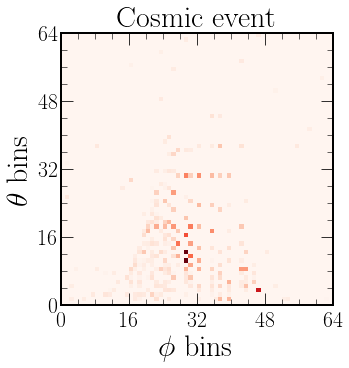

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs.imshow(events[events["t_cosmic_cat"] == 1]["image_0"][cosmic_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs.set_title(r"Cosmic event", fontsize=30)
axs.set_xlabel(r"$\phi$ bins", fontsize=30)
axs.set_ylabel(r"$\theta$ bins", fontsize=30)
axs.label_outer()
chipsnet.plotting.save(save_path + "final_beam_cosmic_event")

In [17]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification

In [18]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform", ["final_beam"], ["t_comb_cat"], exclude_images=False)
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (35042,0.09569), (0,0.00000), (0,0.00000)
Cuts:    (20439,0.97310), (25342,0.92479), (11534,0.73969), (0,0.00000)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.93760,0.68504), Rec: (0.89998,0.86626), F1: (0.91383,0.70066)
- Cat->  Prec: (0.93760,0.68504), Rec: (0.89998,0.86626), F1: (0.91383,0.70066)

- Nuel-> ROC-AUC: 0.84238, PRC-AUC: 0.48345, S-Eff: 0.88928, S-Pur: 0.23349
- FOM1-> 0.27940, 0.91000, 25.68992, 6.77422, 28.92998, 0.66770, 0.41844
- FOM2-> 4.52519, 0.97000, 17.40209, 2.46048, 12.32821, 0.45230, 0.54059

- Numu-> ROC-AUC: 0.68235, PRC-AUC: 0.92760, S-Eff: 0.88252, S-Pur: 0.97974
- FOM1-> 0.86806, 0.33500, 0.62070, 1600.11165, 49.52264, 0.89526, 0.96961
- FOM2-> 1143.25256, 0.99500, 0.00637, 1306.18963, 1.29899, 0.73081, 0.99900

took 47.83 seconds


In [19]:
pca_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

Loading best checkpoint (7)
Explained variation per principal component: [0.15215354 0.11374698]


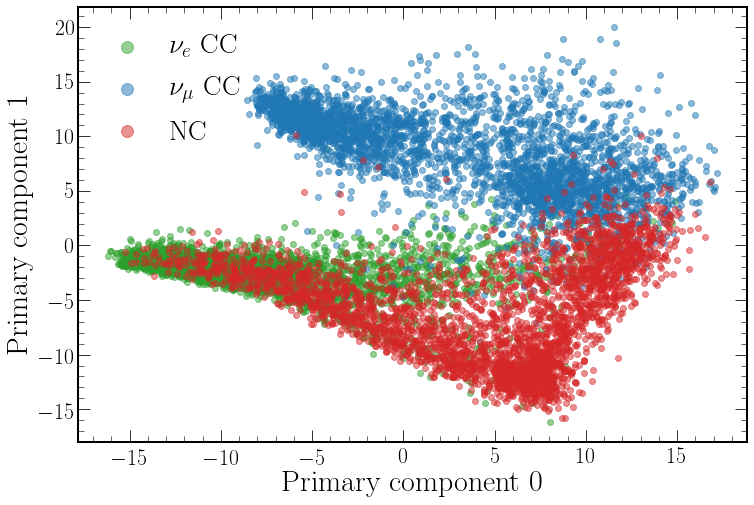

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('Primary component 0', fontsize=30)
axs.set_ylabel('Primary component 1', fontsize=30)
chipsnet.plotting.save(save_path + "final_beam_pca")

In [21]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

Loading best checkpoint (7)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.465s...
[t-SNE] Computed neighbors for 12000 samples in 182.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma:

In [22]:
nuel_index = events["final_beam_pred_t_comb_cat_0"].idxmax()
numu_index = events["final_beam_pred_t_comb_cat_1"].idxmax()
nc_index = events["final_beam_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

Nuel: (-6.280,0.006), Numu: (-8.321,3.164), NC: (7.741,0.987)


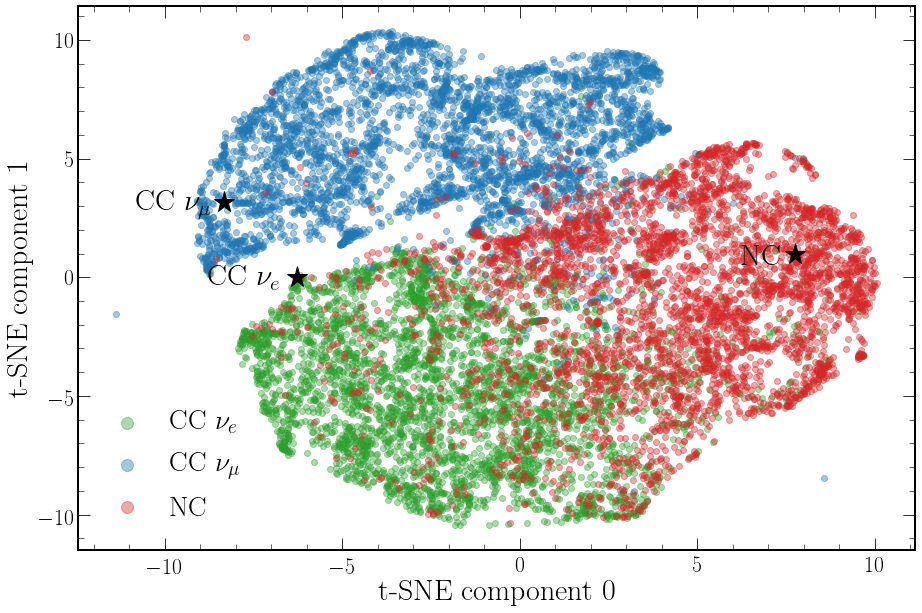

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"CC $\nu_{e}$", alpha=0.4, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"CC $\nu_{\mu}$", alpha=0.4, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.4, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]-2.5, markers_1[0]-0.5, r"CC $\nu_{e}$", fontsize=30, weight="bold")
axs.text(markers_0[1]-2.5, markers_1[1]-0.5, r"CC $\nu_{\mu}$", fontsize=30, weight="bold")
axs.text(markers_0[2]-1.5, markers_1[2]-0.5, r"NC", fontsize=30, weight="bold")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('t-SNE component 0', fontsize=30)
axs.set_ylabel('t-SNE component 1', fontsize=30)
chipsnet.plotting.save(save_path + "final_beam_tsne")

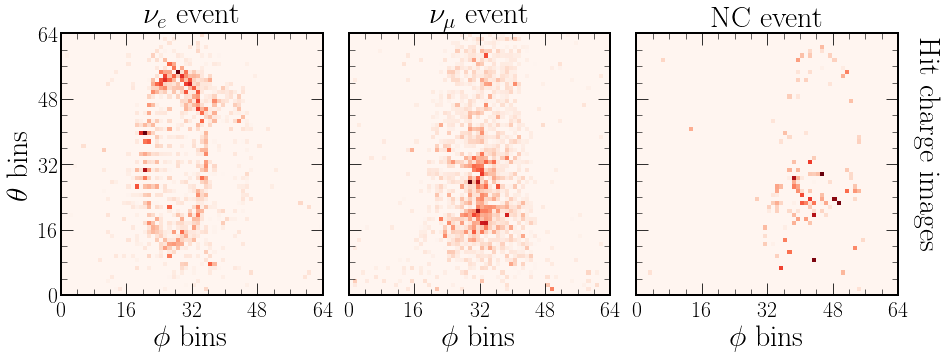

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event", fontsize=30)
axs[0].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[0].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event", fontsize=30)
axs[1].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[1].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event", fontsize=30)
axs[2].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[2].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[2].label_outer()
axs[2].text(68, 12, "Hit charge images", rotation=-90, fontsize=30)
chipsnet.plotting.save(save_path + "final_beam_tsne_events")

In [45]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='explain'></a>

## Explanation: cosmic/beam/energy (explain)

In [46]:
num_events = 10
events, outputs = chipsnet.utils.evaluate(config, "stacked_noreco", exclude_images=False)
cosmic_model = chipsnet.utils.model_from_conf(config, "explain_cosmic")
beam_model = chipsnet.utils.model_from_conf(config, "explain_beam")
energy_model = chipsnet.utils.model_from_conf(config, "explain_energy")


************************ Evaluating stacked_noreco ************************
Weights: (4851,0.00801), (4171,0.00061), (15136,0.22154), (1665,0.04406), (18578,65.16836)
Cuts:    (23344,0.95216), (13298,0.91799), (4330,0.67456), (3805,0.20481)
took 24.77 seconds
Loading best checkpoint (9)
Loading best checkpoint (10)
Loading best checkpoint (5)


In [47]:
# Explain cosmic model
cosmic_activ_1 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_activ_2 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_activ_3 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_activ_1 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block0_path0_conv1")
beam_activ_2 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block1_path0_conv1")
beam_activ_3 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block2_conv1")

# Explain energy model
energy_activ_1 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block0_path0_conv1")
energy_activ_2 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block1_path0_conv1")
energy_activ_3 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block2_conv1")

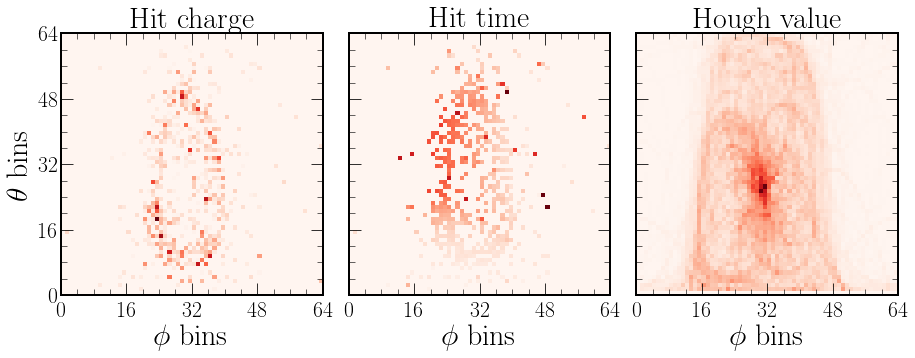

In [48]:
test_event = 5
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][test_event][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"Hit charge", fontsize=30)
axs[0].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[0].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[0].label_outer()
axs[1].imshow(events["image_0"][test_event][:, :, 1], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"Hit time", fontsize=30)
axs[1].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[1].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[1].label_outer()
axs[2].imshow(events["image_0"][test_event][:, :, 2], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"Hough value", fontsize=30)
axs[2].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[2].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[2].label_outer()
chipsnet.plotting.save(save_path + "explain_example_event")

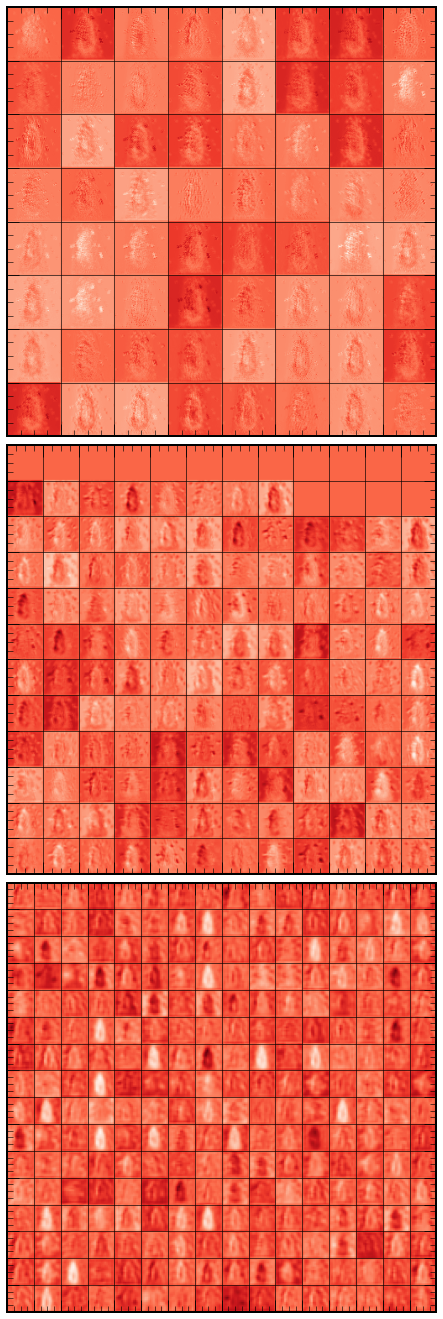

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(cosmic_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(cosmic_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(cosmic_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_cosmic_activations")

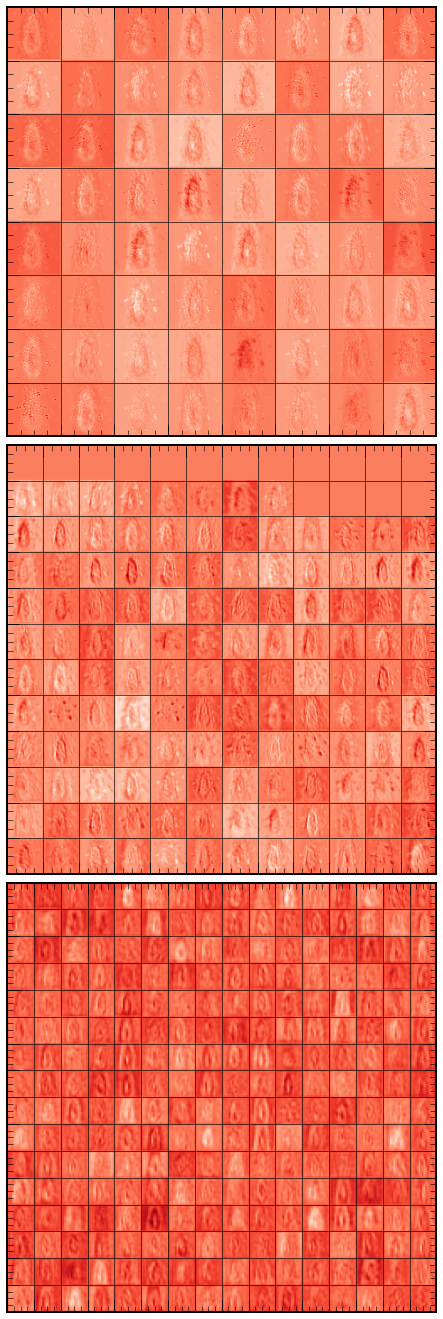

In [54]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(beam_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(beam_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(beam_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_beam_activations")

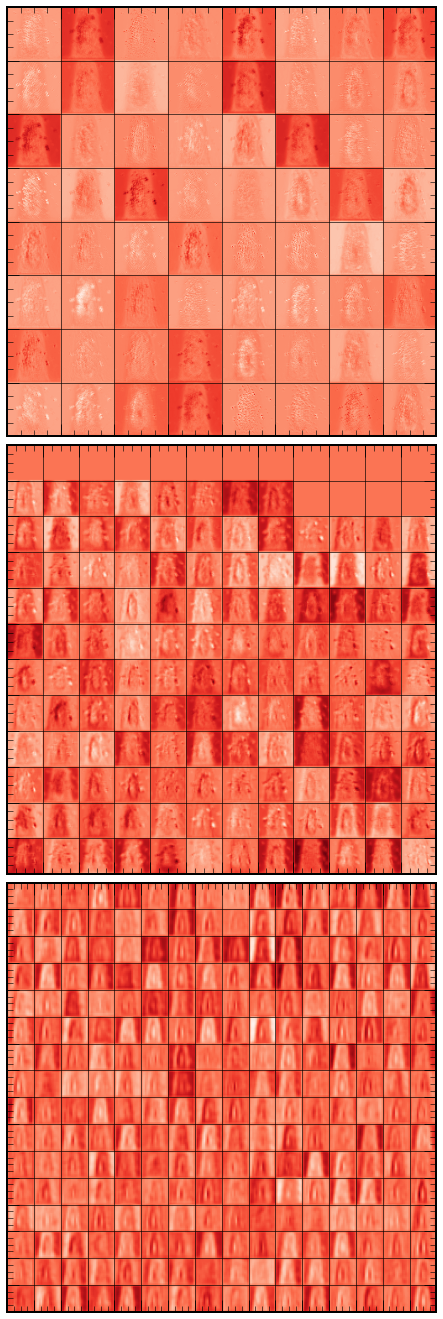

In [55]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(energy_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(energy_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(energy_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_energy_activations")

In [56]:
# Tidy up
del events, outputs, cosmic_model, beam_model, energy_model
del cosmic_activ_1, cosmic_activ_2, cosmic_activ_3
del beam_activ_1, beam_activ_2, beam_activ_3
del energy_activ_1, energy_activ_2, energy_activ_3